In [2]:
# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Local imports
sys.path.insert(0, str(Path.cwd().parents[2]))
from src.colors import COLORS
from src.coherence import (
    compute_cross_spectrum,
    compute_coherence,
    generate_coherent_signals,
    compute_band_coherence,
    compute_all_band_coherence,
    compute_coherence_matrix,
    compute_coherence_matrix_bands,
    compute_coherence_hyperscanning,
    compute_global_coherence_hyperscanning,
    coherence_significance_threshold,
    coherence_surrogate_test,
    compare_with_scipy_coherence,
)

# Plot settings
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

---

## Section 1: Introduction — Correlation in the Frequency Domain

### The Limitation of Time-Domain Correlation

You already know how to compute correlation between two signals in the time domain. But time-domain correlation has a major limitation: **it mixes all frequencies together**.

Consider two musicians playing together:
- They might be perfectly synchronized at the tempo (say, 2 Hz)
- But completely independent in their ornamental flourishes (higher frequencies)

A single correlation coefficient can't capture this frequency-specific relationship.

### Enter Coherence

**Coherence** answers the question: *"How correlated are signals X and Y at each specific frequency?"*

- At 10 Hz (alpha): Are the signals related?
- At 20 Hz (beta): What about here?
- At 40 Hz (gamma): And here?

This is incredibly powerful for neuroscience, where different frequency bands serve different functions.

### Historical Context

Coherence has been used in EEG analysis since the 1960s-70s. It remains one of the most widely used connectivity measures because:

- It's mathematically well-understood
- It's easy to compute and interpret
- It provides frequency-specific information

> **Key Message**: Coherence tells us how correlated two signals are at each frequency — it's correlation in the frequency domain.

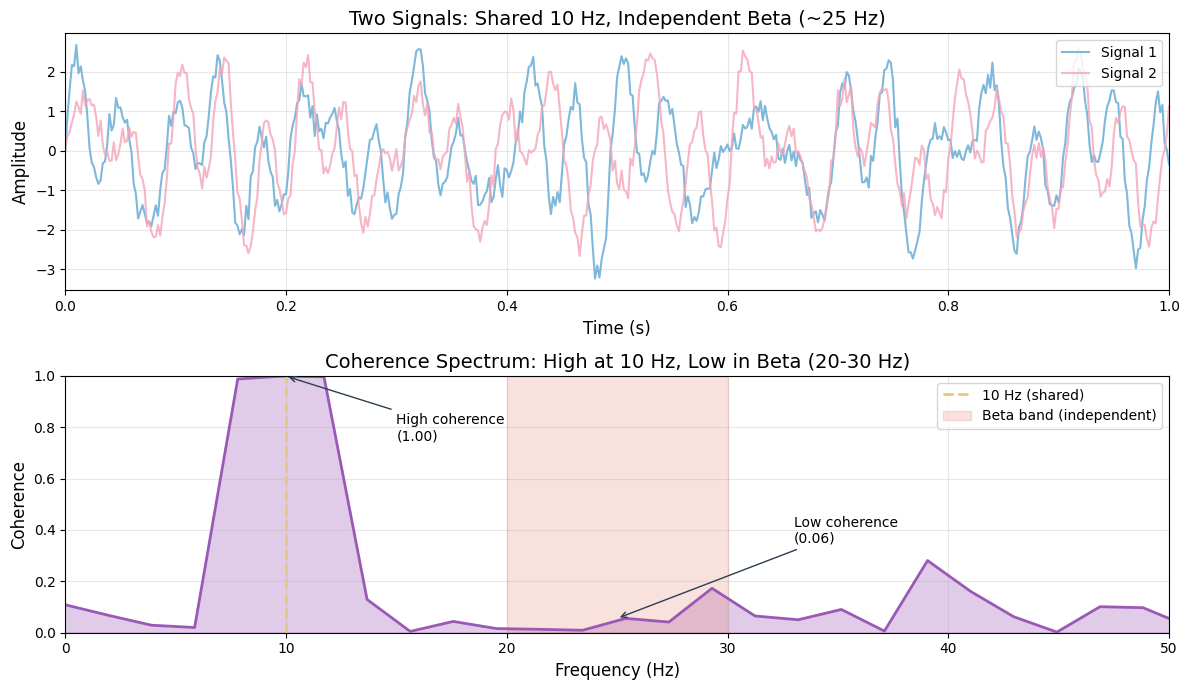

Coherence reveals FREQUENCY-SPECIFIC correlation between signals.


In [3]:
# =============================================================================
# Visualization 1: Frequency-Specific Coherence
# =============================================================================

# Parameters
fs = 500  # Sampling frequency
duration = 4  # seconds
n_samples = int(fs * duration)
t = np.arange(n_samples) / fs
np.random.seed(42)

# Create two signals:
# - Correlated at 10 Hz (alpha) - SAME sinusoid (high coherence)
# - Uncorrelated around 25 Hz (beta) - INDEPENDENT noise (low coherence)

# Shared 10 Hz component (will have HIGH coherence)
shared_alpha = np.sin(2 * np.pi * 10 * t)

# Independent beta-band noise (will have LOW coherence)
# Use filtered noise - truly independent between signals
from scipy.signal import butter, filtfilt

def bandpass(data, low, high, fs, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, data)

# Independent noise in beta band (20-30 Hz)
beta_noise_1 = bandpass(np.random.randn(n_samples), 20, 30, fs)
beta_noise_2 = bandpass(np.random.randn(n_samples), 20, 30, fs)

# Normalize to similar amplitude as alpha
beta_noise_1 = beta_noise_1 / np.std(beta_noise_1)
beta_noise_2 = beta_noise_2 / np.std(beta_noise_2)

# Combine: shared alpha + independent beta noise
signal_1 = shared_alpha + beta_noise_1 + 0.2 * np.random.randn(n_samples)
signal_2 = shared_alpha + beta_noise_2 + 0.2 * np.random.randn(n_samples)

# Compute coherence
freqs, coh = compute_coherence(signal_1, signal_2, fs, nperseg=256)

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(12, 7))

# Top panel: Time series
ax1 = axes[0]
time_window = (0, 1)  # Show 1 second
mask = (t >= time_window[0]) & (t <= time_window[1])
ax1.plot(t[mask], signal_1[mask], color=COLORS['signal_1'], label='Signal 1', linewidth=1.5)
ax1.plot(t[mask], signal_2[mask], color=COLORS['signal_2'], label='Signal 2', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_title('Two Signals: Shared 10 Hz, Independent Beta (~25 Hz)', fontsize=14)
ax1.legend(loc='upper right')
ax1.set_xlim(time_window)

# Bottom panel: Coherence spectrum
ax2 = axes[1]
ax2.fill_between(freqs, 0, coh, alpha=0.3, color=COLORS['high_sync'])
ax2.plot(freqs, coh, color=COLORS['high_sync'], linewidth=2)
ax2.axvline(10, color=COLORS['signal_4'], linestyle='--', linewidth=2, label='10 Hz (shared)')
ax2.axvspan(20, 30, color=COLORS['negative'], alpha=0.2, label='Beta band (independent)')
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Coherence', fontsize=12)
ax2.set_title('Coherence Spectrum: High at 10 Hz, Low in Beta (20-30 Hz)', fontsize=14)
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

# Add annotations - use actual coherence values
idx_10hz = np.argmin(np.abs(freqs - 10))
idx_25hz = np.argmin(np.abs(freqs - 25))
coh_10 = coh[idx_10hz]
coh_25 = coh[idx_25hz]

ax2.annotate(f'High coherence\n({coh_10:.2f})', xy=(10, coh_10), xytext=(15, 0.75),
             fontsize=10, ha='left',
             arrowprops=dict(arrowstyle='->', color=COLORS['text']))
ax2.annotate(f'Low coherence\n({coh_25:.2f})', xy=(25, coh_25), xytext=(33, 0.35),
             fontsize=10, ha='left',
             arrowprops=dict(arrowstyle='->', color=COLORS['text']))

plt.tight_layout()
plt.show()

print("Coherence reveals FREQUENCY-SPECIFIC correlation between signals.")

---

## Section 2: The Mathematics of Coherence

### Building Blocks

Coherence is built from three components:

**1. Cross-Spectral Density (CSD)**

$$S_{xy}(f) = \mathbb{E}[X(f) \cdot Y^*(f)]$$

The CSD measures how much X and Y co-vary at each frequency. It's complex-valued:
- **Magnitude**: strength of relationship
- **Phase**: timing relationship (lead/lag)

**2. Power Spectral Density (PSD)**

$$S_{xx}(f) = |X(f)|^2 \quad \text{and} \quad S_{yy}(f) = |Y(f)|^2$$

The power of each signal at each frequency.

**3. Coherence**

$$C_{xy}(f) = \frac{|S_{xy}(f)|^2}{S_{xx}(f) \cdot S_{yy}(f)}$$

### Key Properties

| Property | Value | Meaning |
|----------|-------|--------|
| Range | 0 to 1 | Normalized measure |
| C = 1 | Perfect | Complete linear relationship at frequency f |
| C = 0 | None | No linear relationship at frequency f |
| Symmetric | C_xy = C_yx | No directionality information |
| Interpretation | R² | Fraction of power at f **shared** between X and Y |

### Intuition

Think of coherence as the **squared correlation coefficient at each frequency**:
- If C(10 Hz) = 0.64, then 64% of the 10 Hz activity is **common** to both X and Y
- The remaining 36% is independent in each signal
- Note: Coherence is **symmetric** — it cannot tell us if X drives Y or Y drives X

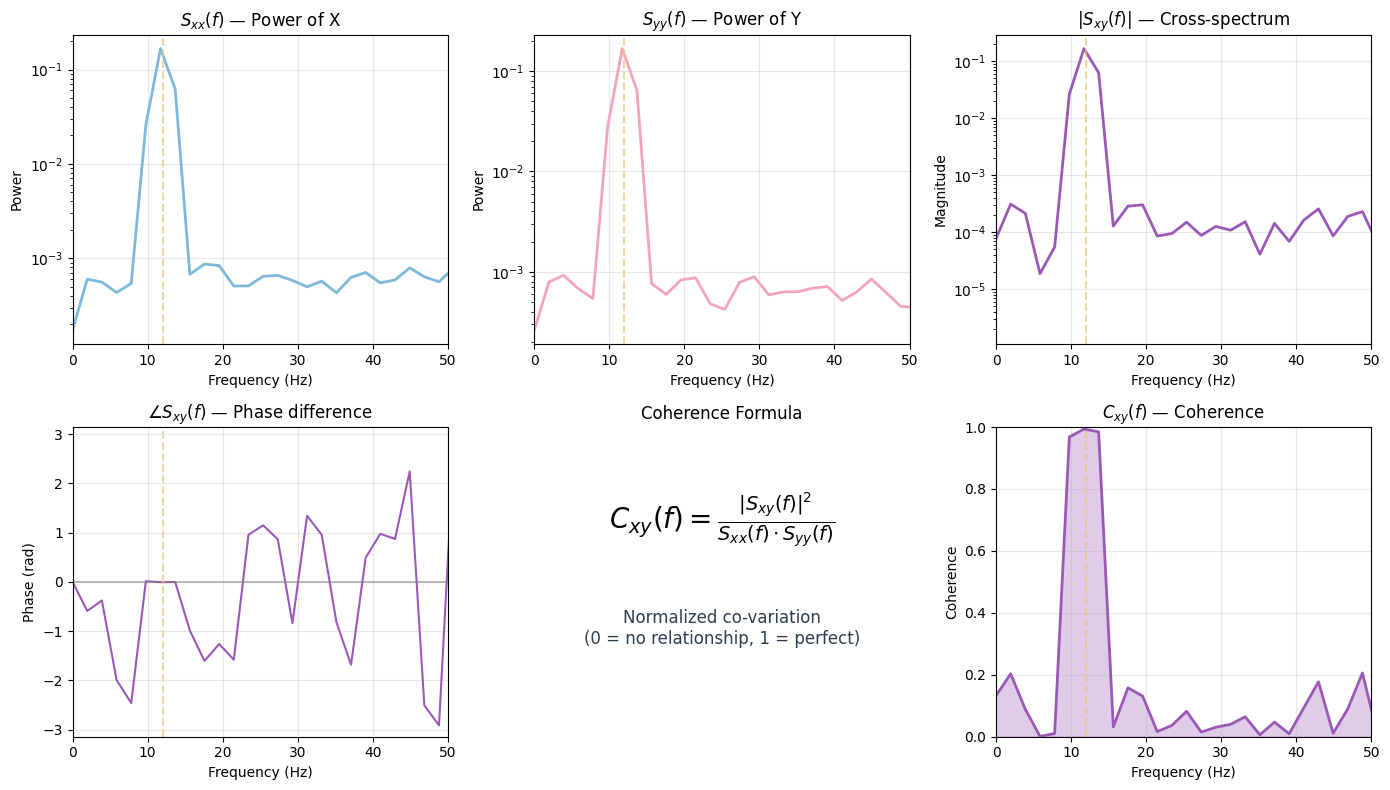

In [4]:
# =============================================================================
# Visualization 2: Coherence Formula Components
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Generate example signals
np.random.seed(123)
fs = 500
t = np.arange(2000) / fs
freq_target = 12  # Hz

# Shared + independent components
shared = np.sin(2 * np.pi * freq_target * t)
x = shared + 0.4 * np.random.randn(len(t))
y = shared + 0.4 * np.random.randn(len(t))

# Compute spectra
freqs_psd, psd_x = signal.welch(x, fs, nperseg=256)
_, psd_y = signal.welch(y, fs, nperseg=256)
freqs_csd, csd_xy = signal.csd(x, y, fs, nperseg=256)
freqs_coh, coh_xy = compute_coherence(x, y, fs, nperseg=256)

# Plot 1: Signal X PSD
ax = axes[0, 0]
ax.semilogy(freqs_psd, psd_x, color=COLORS['signal_1'], linewidth=2)
ax.set_title(r'$S_{xx}(f)$ — Power of X', fontsize=12)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
ax.set_xlim(0, 50)
ax.axvline(freq_target, color=COLORS['signal_4'], linestyle='--', alpha=0.7)

# Plot 2: Signal Y PSD
ax = axes[0, 1]
ax.semilogy(freqs_psd, psd_y, color=COLORS['signal_2'], linewidth=2)
ax.set_title(r'$S_{yy}(f)$ — Power of Y', fontsize=12)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
ax.set_xlim(0, 50)
ax.axvline(freq_target, color=COLORS['signal_4'], linestyle='--', alpha=0.7)

# Plot 3: Cross-spectrum magnitude
ax = axes[0, 2]
ax.semilogy(freqs_csd, np.abs(csd_xy), color=COLORS['high_sync'], linewidth=2)
ax.set_title(r'$|S_{xy}(f)|$ — Cross-spectrum', fontsize=12)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, 50)
ax.axvline(freq_target, color=COLORS['signal_4'], linestyle='--', alpha=0.7)

# Plot 4: Cross-spectrum phase
ax = axes[1, 0]
ax.plot(freqs_csd, np.angle(csd_xy), color=COLORS['high_sync'], linewidth=1.5)
ax.set_title(r'$\angle S_{xy}(f)$ — Phase difference', fontsize=12)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase (rad)')
ax.set_xlim(0, 50)
ax.set_ylim(-np.pi, np.pi)
ax.axhline(0, color='gray', linestyle='-', alpha=0.5)
ax.axvline(freq_target, color=COLORS['signal_4'], linestyle='--', alpha=0.7)

# Plot 5: Formula visualization
ax = axes[1, 1]
ax.text(0.5, 0.7, r'$C_{xy}(f) = \frac{|S_{xy}(f)|^2}{S_{xx}(f) \cdot S_{yy}(f)}$',
        fontsize=20, ha='center', va='center', transform=ax.transAxes)
ax.text(0.5, 0.35, 'Normalized co-variation\n(0 = no relationship, 1 = perfect)',
        fontsize=12, ha='center', va='center', transform=ax.transAxes, color=COLORS['text'])
ax.axis('off')
ax.set_title('Coherence Formula', fontsize=12)

# Plot 6: Coherence result
ax = axes[1, 2]
ax.fill_between(freqs_coh, 0, coh_xy, alpha=0.3, color=COLORS['high_sync'])
ax.plot(freqs_coh, coh_xy, color=COLORS['high_sync'], linewidth=2)
ax.set_title(r'$C_{xy}(f)$ — Coherence', fontsize=12)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Coherence')
ax.set_xlim(0, 50)
ax.set_ylim(0, 1)
ax.axvline(freq_target, color=COLORS['signal_4'], linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

---

## Section 3: Estimating Coherence with Welch's Method

### The Problem with Raw Periodograms

If you compute coherence from a single FFT, you'll always get **coherence = 1** at every frequency! Why?

Because with a single realization, there's no way to distinguish "true relationship" from "chance alignment."

### The Solution: Averaging

**Welch's method** divides the signal into overlapping segments, computes spectra for each segment, and averages:

1. Divide signals into K overlapping segments
2. Window each segment (Hanning, Hamming, etc.)
3. Compute FFT of each segment
4. **Average** cross-spectra and power spectra across segments
5. Compute coherence from the **averaged** spectra

### Why Averaging Works

- **Noise** fluctuates randomly → averages toward zero
- **True relationship** is consistent → survives averaging

### The Trade-off

| More segments | Fewer segments |
|--------------|----------------|
| Better coherence estimate | Worse coherence estimate |
| Worse frequency resolution | Better frequency resolution |
| Need longer data | Works with short data |

> **Rule of thumb**: You need at least 5-10 segments for a reliable coherence estimate.

/var/folders/tw/x1b5ldls1_s1t0h65sy4nsym0000gp/T/ipykernel_42257/2595963676.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


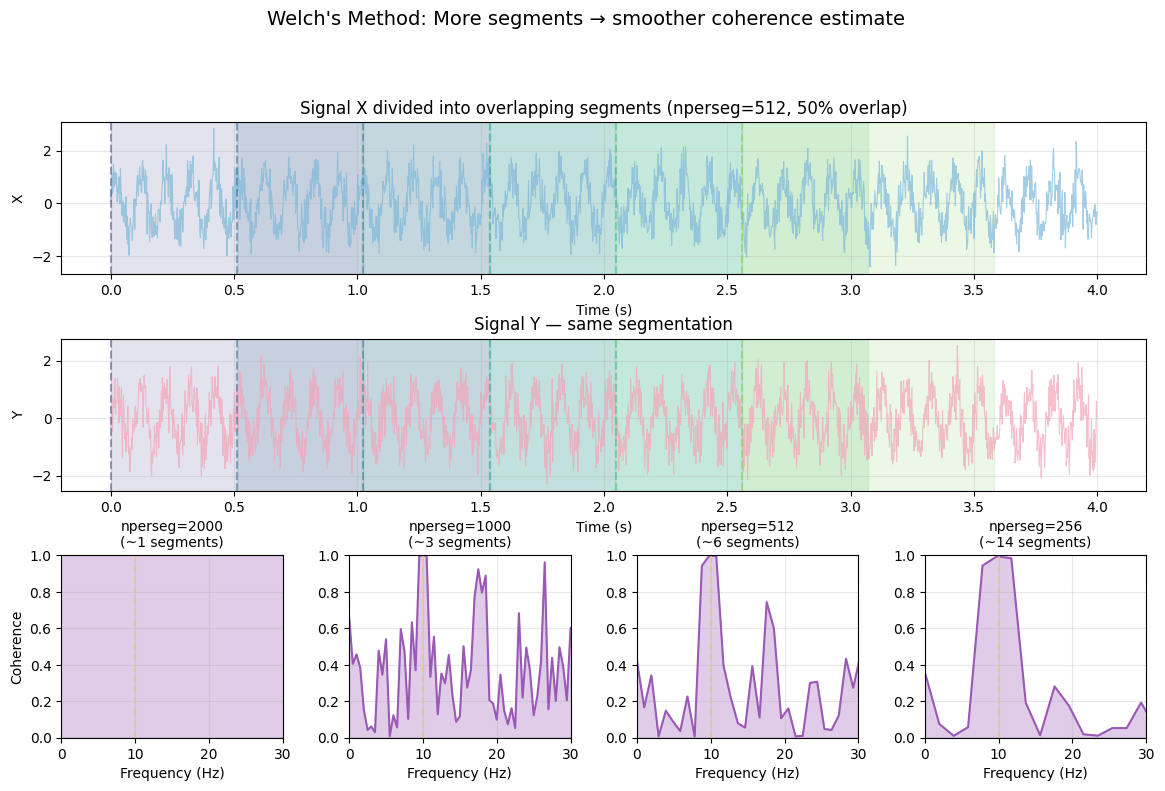

More segments = better estimate but worse frequency resolution.


In [5]:
# =============================================================================
# Visualization 3: Welch's Method for Coherence
# =============================================================================

fig = plt.figure(figsize=(14, 8))

# Generate signals
np.random.seed(42)
fs = 500
duration = 4
n_samples = int(fs * duration)
t = np.arange(n_samples) / fs

# Correlated signals at 10 Hz
shared = np.sin(2 * np.pi * 10 * t)
x = shared + 0.5 * np.random.randn(n_samples)
y = shared + 0.5 * np.random.randn(n_samples)

nperseg = 512
noverlap = nperseg // 2
n_segments = (n_samples - noverlap) // (nperseg - noverlap)

# Create layout
gs = fig.add_gridspec(3, 4, height_ratios=[1, 1, 1.2], hspace=0.4, wspace=0.3)

# Row 1: Show segments for signal X
ax_x = fig.add_subplot(gs[0, :])
ax_x.plot(t, x, color=COLORS['signal_1'], linewidth=0.8, alpha=0.7)
colors_segments = plt.cm.viridis(np.linspace(0.2, 0.8, min(n_segments, 6)))
for i in range(min(n_segments, 6)):
    start = i * (nperseg - noverlap)
    end = start + nperseg
    if end <= n_samples:
        ax_x.axvspan(t[start], t[end-1], alpha=0.15, color=colors_segments[i])
        ax_x.axvline(t[start], color=colors_segments[i], linestyle='--', alpha=0.5)
ax_x.set_title(f'Signal X divided into overlapping segments (nperseg={nperseg}, 50% overlap)', fontsize=12)
ax_x.set_xlabel('Time (s)')
ax_x.set_ylabel('X')

# Row 2: Show segments for signal Y
ax_y = fig.add_subplot(gs[1, :])
ax_y.plot(t, y, color=COLORS['signal_2'], linewidth=0.8, alpha=0.7)
for i in range(min(n_segments, 6)):
    start = i * (nperseg - noverlap)
    end = start + nperseg
    if end <= n_samples:
        ax_y.axvspan(t[start], t[end-1], alpha=0.15, color=colors_segments[i])
        ax_y.axvline(t[start], color=colors_segments[i], linestyle='--', alpha=0.5)
ax_y.set_title(f'Signal Y — same segmentation', fontsize=12)
ax_y.set_xlabel('Time (s)')
ax_y.set_ylabel('Y')

# Row 3: Effect of number of segments
nperseg_values = [2000, 1000, 512, 256]
for idx, nps in enumerate(nperseg_values):
    ax = fig.add_subplot(gs[2, idx])
    freqs, coh = compute_coherence(x, y, fs, nperseg=nps)
    n_segs = (n_samples - nps//2) // (nps - nps//2)
    
    ax.fill_between(freqs, 0, coh, alpha=0.3, color=COLORS['high_sync'])
    ax.plot(freqs, coh, color=COLORS['high_sync'], linewidth=1.5)
    ax.axvline(10, color=COLORS['signal_4'], linestyle='--', alpha=0.7)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 1)
    ax.set_title(f'nperseg={nps}\n(~{n_segs} segments)', fontsize=10)
    ax.set_xlabel('Frequency (Hz)')
    if idx == 0:
        ax.set_ylabel('Coherence')

plt.suptitle('Welch\'s Method: More segments → smoother coherence estimate', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("More segments = better estimate but worse frequency resolution.")

---

## Section 4: Coherence of Simple Signals

Let's build intuition by examining coherence in controlled scenarios. Understanding these simple cases will help you interpret coherence in real EEG data.

### Key Questions

1. What happens when signals are identical?
2. How does noise affect coherence?
3. Does phase shift change coherence?
4. What about amplitude scaling?
5. What do uncorrelated signals look like?
6. Can we have frequency-specific coherence?

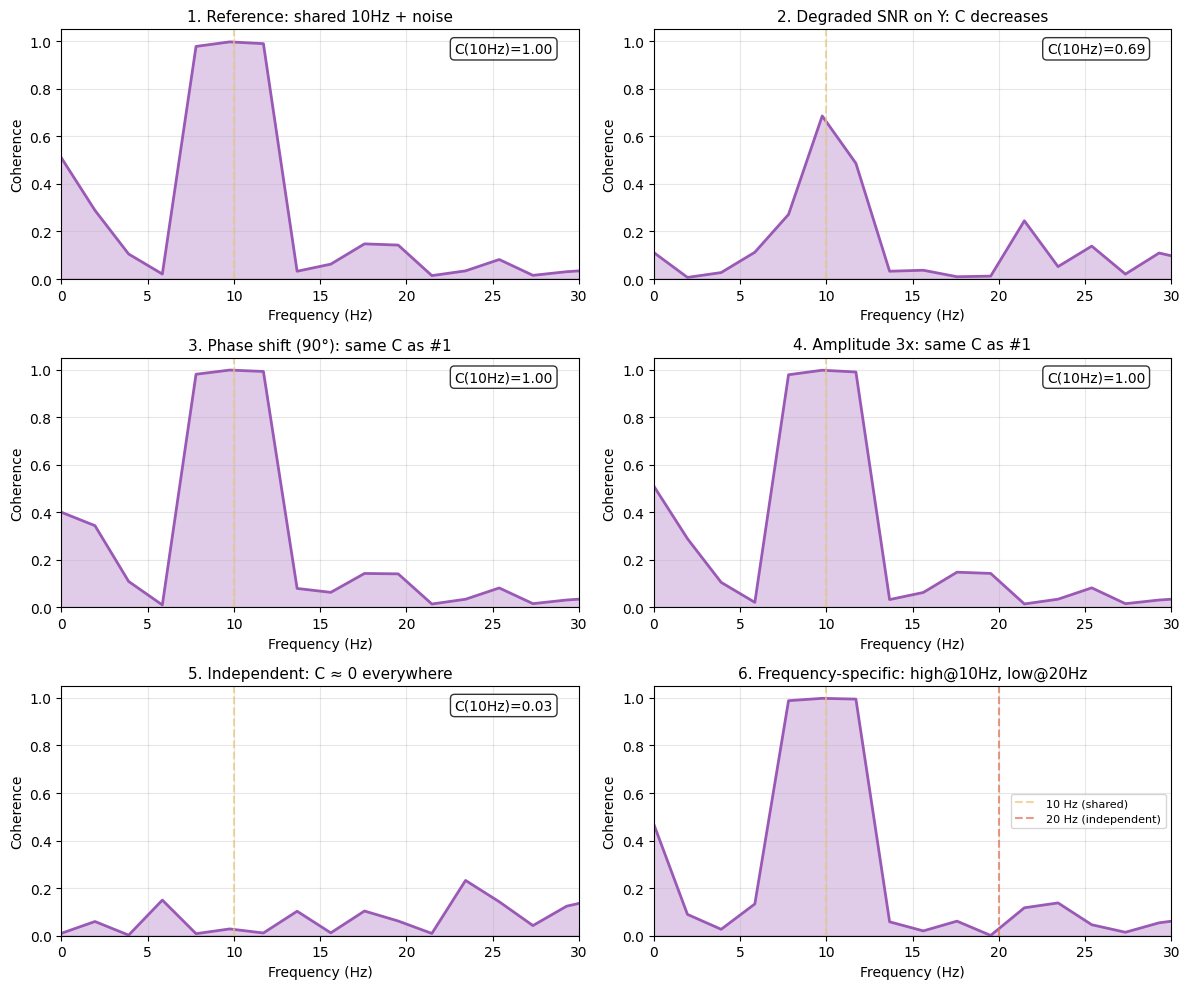

Key insight: Compare #1, #3, #4 — coherence is INVARIANT to phase shifts and amplitude scaling!
But degrading SNR (#2) or removing shared components (#5) destroys coherence.


In [22]:
# =============================================================================
# Visualization 4: Coherence in Different Scenarios (3x2 grid)
# =============================================================================

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

fs = 500
n_samples = 2000
t = np.arange(n_samples) / fs
freq = 10  # Hz

# Helper function for subplot
def plot_scenario(ax, x, y, title, fs=500):
    freqs, coh = compute_coherence(x, y, fs, nperseg=256)
    ax.fill_between(freqs, 0, coh, alpha=0.3, color=COLORS['high_sync'])
    ax.plot(freqs, coh, color=COLORS['high_sync'], linewidth=2)
    ax.axvline(freq, color=COLORS['signal_4'], linestyle='--', alpha=0.7)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 1.05)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Coherence')
    # Add coherence value at target frequency
    idx = np.argmin(np.abs(freqs - freq))
    ax.text(0.95, 0.95, f'C({freq}Hz)={coh[idx]:.2f}', transform=ax.transAxes,
            ha='right', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ============================================================================
# Fixed seed for reproducibility across scenarios 1, 3, 4
# ============================================================================
np.random.seed(123)
noise_x = 0.3 * np.random.randn(n_samples)
noise_y = 0.3 * np.random.randn(n_samples)

base_signal = np.sin(2 * np.pi * freq * t)

# Scenario 1: Reference - shared signal + noise
x1 = base_signal + noise_x
y1 = base_signal + noise_y
plot_scenario(axes[0, 0], x1, y1, '1. Reference: shared 10Hz + noise')

# Scenario 2: Much weaker signal in Y → coherence decreases
# FIX: To actually decrease coherence, we need to degrade the SNR substantially
np.random.seed(456)
x2 = base_signal + noise_x
y2 = 0.2 * base_signal + 1.5 * np.random.randn(n_samples)  # Weak signal + strong noise
plot_scenario(axes[0, 1], x2, y2, '2. Degraded SNR on Y: C decreases')

# Scenario 3: Phase-shifted - same noise as scenario 1
# Coherence is phase-invariant: only the phase relationship changes, not coherence
x3 = base_signal + noise_x
y3 = np.sin(2 * np.pi * freq * t + np.pi/2) + noise_y
plot_scenario(axes[1, 0], x3, y3, '3. Phase shift (90°): same C as #1')

# Scenario 4: Amplitude scaled - same noise as scenario 1
# FIX: Scale EVERYTHING (signal + noise) to preserve SNR
# Coherence is scale-invariant: C(x, k*y) = C(x, y) for any k ≠ 0
x4 = base_signal + noise_x
y4 = 3.0 * (base_signal + noise_y)  # Global gain, SNR preserved
plot_scenario(axes[1, 1], x4, y4, '4. Amplitude 3x: same C as #1')

# Scenario 5: Uncorrelated - completely independent signals
np.random.seed(789)
x5 = base_signal + 0.3 * np.random.randn(n_samples)
y5 = np.random.randn(n_samples)  # No shared component
plot_scenario(axes[2, 0], x5, y5, '5. Independent: C ≈ 0 everywhere')

# Scenario 6: Frequency-specific coupling
np.random.seed(101)
shared_10hz = np.sin(2 * np.pi * 10 * t)

# Independent narrowband components around 20 Hz
from scipy.signal import butter, filtfilt

def bandpass(data, low, high, fs):
    b, a = butter(4, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, data)

indep_20hz_x = bandpass(np.random.randn(n_samples), 18, 22, fs)
indep_20hz_y = bandpass(np.random.randn(n_samples), 18, 22, fs)

x6 = shared_10hz + indep_20hz_x + 0.2 * np.random.randn(n_samples)
y6 = shared_10hz + indep_20hz_y + 0.2 * np.random.randn(n_samples)

ax = axes[2, 1]
freqs, coh = compute_coherence(x6, y6, fs, nperseg=256)
ax.fill_between(freqs, 0, coh, alpha=0.3, color=COLORS['high_sync'])
ax.plot(freqs, coh, color=COLORS['high_sync'], linewidth=2)
ax.axvline(10, color=COLORS['signal_4'], linestyle='--', alpha=0.7, label='10 Hz (shared)')
ax.axvline(20, color=COLORS['negative'], linestyle='--', alpha=0.7, label='20 Hz (independent)')
ax.set_xlim(0, 30)
ax.set_ylim(0, 1.05)
ax.set_title('6. Frequency-specific: high@10Hz, low@20Hz', fontsize=11)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Coherence')
ax.legend(loc='right', fontsize=8)

plt.tight_layout()
plt.show()

print("Key insight: Compare #1, #3, #4 — coherence is INVARIANT to phase shifts and amplitude scaling!")
print("But degrading SNR (#2) or removing shared components (#5) destroys coherence.")

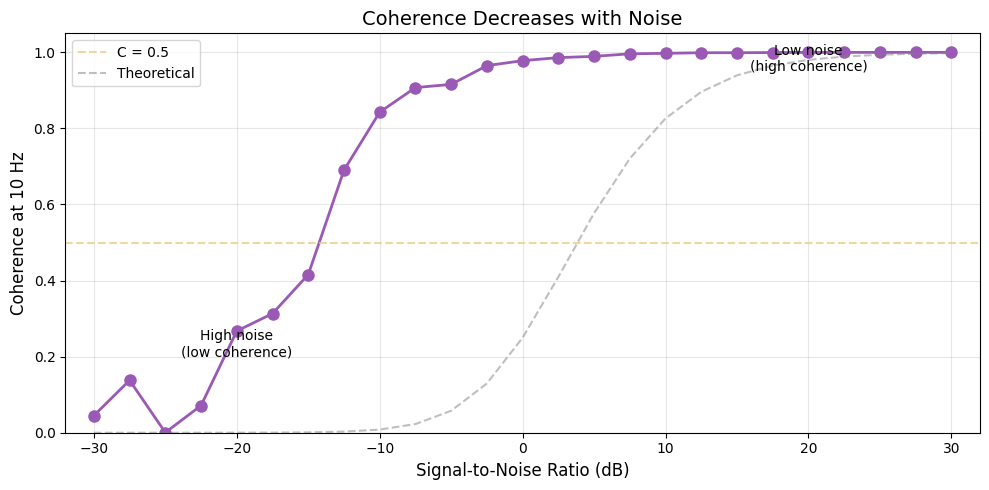

Coherence range: 0.00 to 1.00


In [23]:
# =============================================================================
# Visualization 5: Coherence vs SNR (FIXED)
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 5))

fs = 500
n_samples = 4000
t = np.arange(n_samples) / fs
freq = 10

# Wider SNR range to see full degradation
snr_db_values = np.linspace(-30, 30, 25)
coherence_at_target = []

base_signal = np.sin(2 * np.pi * freq * t)
signal_power = 0.5  # Power of sin with amplitude 1

np.random.seed(42)

for snr_db in snr_db_values:
    # SNR = signal_power / noise_power
    # snr_db = 10 * log10(SNR)  →  SNR = 10^(snr_db/10)
    snr_linear = 10 ** (snr_db / 10)  # FIX: /10 for power ratio, not /20
    noise_power = signal_power / snr_linear
    noise_std = np.sqrt(noise_power)
    
    x = base_signal + noise_std * np.random.randn(n_samples)
    y = base_signal + noise_std * np.random.randn(n_samples)
    
    freqs, coh = compute_coherence(x, y, fs, nperseg=256)
    idx = np.argmin(np.abs(freqs - freq))
    coherence_at_target.append(coh[idx])

ax.plot(snr_db_values, coherence_at_target, 'o-', color=COLORS['high_sync'], 
        linewidth=2, markersize=8)
ax.axhline(0.5, color=COLORS['signal_4'], linestyle='--', alpha=0.7, label='C = 0.5')
ax.set_xlabel('Signal-to-Noise Ratio (dB)', fontsize=12)
ax.set_ylabel(f'Coherence at {freq} Hz', fontsize=12)
ax.set_title('Coherence Decreases with Noise', fontsize=14)
ax.set_ylim(0, 1.05)
ax.set_xlim(-32, 32)
ax.legend()

# Annotations repositioned for the new curve
ax.annotate('High noise\n(low coherence)', xy=(-20, 0.2), fontsize=10, ha='center')
ax.annotate('Low noise\n(high coherence)', xy=(20, 0.95), fontsize=10, ha='center')

# Add theoretical curve for reference
# For x = s + n1, y = s + n2 with independent noises:
# C(f) ≈ SNR² / (1 + SNR)² at signal frequency
snr_theory = 10 ** (snr_db_values / 10)
coh_theory = snr_theory**2 / (1 + snr_theory)**2
ax.plot(snr_db_values, coh_theory, '--', color='gray', alpha=0.5, label='Theoretical')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Coherence range: {min(coherence_at_target):.2f} to {max(coherence_at_target):.2f}")

---

## Section 5: Interpreting Coherence Values

### What Does Coherence Really Mean?

| Coherence | Interpretation | R² (variance explained) |
|-----------|----------------|------------------------|
| 0.9 - 1.0 | Very strong | 81-100% |
| 0.7 - 0.9 | Strong | 49-81% |
| 0.5 - 0.7 | Moderate | 25-49% |
| 0.3 - 0.5 | Weak | 9-25% |
| 0.0 - 0.3 | Very weak / None | 0-9% |

### Important Caveats

**High coherence does NOT mean**:
- Causation (A causes B)
- Direct connection (could be common input)
- Neural coupling (could be volume conduction!)

**Low coherence does NOT mean**:
- No relationship (could be nonlinear)
- Independence (could be related at other frequencies)

### The Squared Coherence Interpretation

Since coherence is already "squared" (magnitude-squared coherence), you can interpret it directly as **fraction of variance explained**:

- C = 0.8 means 80% of Y's power at that frequency can be linearly predicted from X
- The remaining 20% is independent

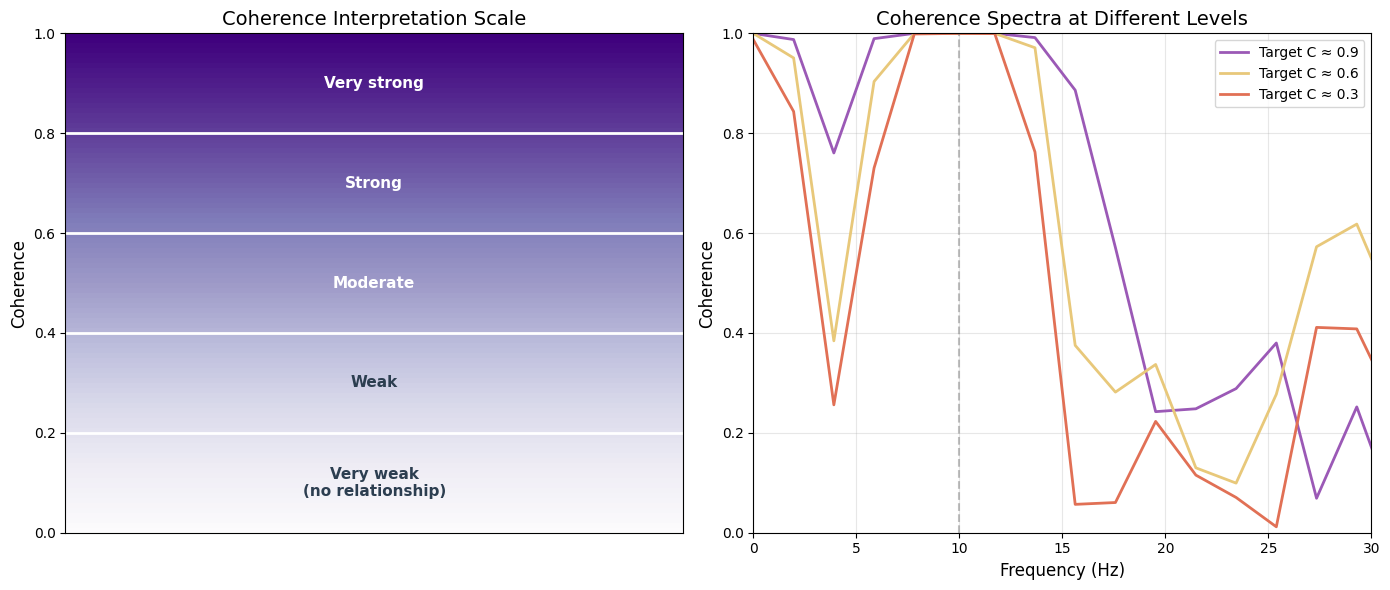

In [8]:
# =============================================================================
# Visualization 6: Coherence Interpretation Scale
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Coherence scale with examples
ax1 = axes[0]

# Create color gradient
coherence_levels = np.linspace(0, 1, 100)
gradient = np.vstack([coherence_levels] * 10)

# Plot gradient
im = ax1.imshow(gradient.T, aspect='auto', extent=[0, 1, 0, 1], 
                cmap='Purples', origin='lower')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Add labeled regions
regions = [
    (0.0, 0.2, 'Very weak\n(no relationship)', '#f0f0f0'),
    (0.2, 0.4, 'Weak', '#d0d0e8'),
    (0.4, 0.6, 'Moderate', '#a0a0d0'),
    (0.6, 0.8, 'Strong', '#7070b8'),
    (0.8, 1.0, 'Very strong', '#4040a0'),
]

for y_low, y_high, label, color in regions:
    ax1.axhline(y_low, color='white', linewidth=2)
    ax1.text(0.5, (y_low + y_high) / 2, label, ha='center', va='center',
             fontsize=11, fontweight='bold', color='white' if y_high > 0.5 else COLORS['text'])

ax1.set_xlabel('', fontsize=12)
ax1.set_ylabel('Coherence', fontsize=12)
ax1.set_title('Coherence Interpretation Scale', fontsize=14)
ax1.set_xticks([])
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Right panel: Example signals at different coherence levels
ax2 = axes[1]
np.random.seed(42)

fs = 500
n_samples = 1000
t = np.arange(n_samples) / fs
freq = 10

target_coherences = [0.9, 0.6, 0.3]
colors = [COLORS['high_sync'], COLORS['signal_4'], COLORS['negative']]

for i, (target_coh, color) in enumerate(zip(target_coherences, colors)):
    # Generate signals with approximate target coherence
    x, y = generate_coherent_signals(n_samples, fs, freq, target_coh, snr_db=30, seed=42+i)
    freqs, coh = compute_coherence(x, y, fs, nperseg=256)
    
    ax2.plot(freqs, coh, color=color, linewidth=2, label=f'Target C ≈ {target_coh}')

ax2.axvline(freq, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlim(0, 30)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Coherence', fontsize=12)
ax2.set_title('Coherence Spectra at Different Levels', fontsize=14)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

---

## Section 6: The Volume Conduction Problem

### Recall from C01: Volume Conduction

In EEG, electrical signals spread through the conductive brain tissue and skull. A **single source** can appear at **multiple electrodes** simultaneously.

### Why This Breaks Coherence

When two electrodes pick up the same source:
- They record nearly identical signals
- Coherence between them is **very high** (~1)
- But this is NOT true connectivity — it's the same signal seen twice!

### The Signature of Volume Conduction

Volume conduction has a distinctive signature:
- **Zero phase lag**: The signals are (nearly) instantaneous copies
- **High coherence**: Because they're the same signal

### Why Coherence Can't Help

Coherence uses only the **magnitude** of the cross-spectrum:

$$C_{xy}(f) = \frac{|S_{xy}(f)|^2}{S_{xx}(f) \cdot S_{yy}(f)}$$

The **phase information is discarded**! So coherence can't distinguish:
- Zero-lag (volume conduction) from
- True lagged connectivity (neural communication)

### Solutions

1. **Imaginary coherence** (F02): Uses only the imaginary part of coherence
2. **PLI / wPLI** (G02, G03): Phase-based metrics that ignore zero-lag
3. **Source localization**: Analyze at the source level, not sensor level

> **For hyperscanning**: Volume conduction is less critical for BETWEEN-brain connectivity (separate heads!), but still matters for WITHIN-brain analysis.

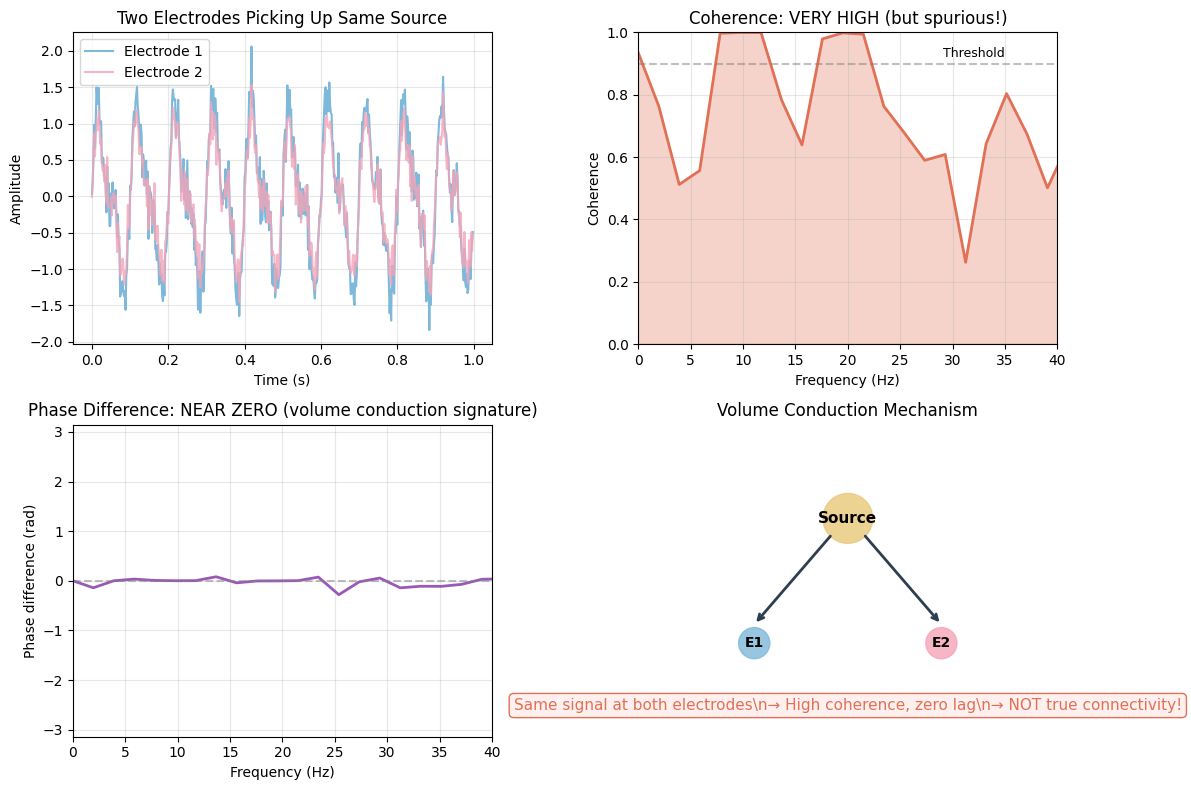

⚠️  Volume conduction creates HIGH coherence with ZERO phase lag — this is NOT true connectivity!


In [9]:
# =============================================================================
# Visualization 7: Volume Conduction Creates Spurious Coherence
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
np.random.seed(42)

fs = 500
n_samples = 2000
t = np.arange(n_samples) / fs

# Simulate a single source
source = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 20 * t)
source += 0.2 * np.random.randn(n_samples)

# Two electrodes pick up this source (with slight amplitude differences)
electrode_1 = 1.0 * source + 0.1 * np.random.randn(n_samples)
electrode_2 = 0.8 * source + 0.1 * np.random.randn(n_samples)

# Compute coherence and cross-spectrum
freqs, coh = compute_coherence(electrode_1, electrode_2, fs, nperseg=256)
freqs_csd, csd_xy = signal.csd(electrode_1, electrode_2, fs, nperseg=256)
phase_diff = np.angle(csd_xy)

# Plot 1: Time series
ax = axes[0, 0]
t_plot = t[:500]
ax.plot(t_plot, electrode_1[:500], color=COLORS['signal_1'], label='Electrode 1', linewidth=1.5)
ax.plot(t_plot, electrode_2[:500], color=COLORS['signal_2'], label='Electrode 2', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Two Electrodes Picking Up Same Source', fontsize=12)
ax.legend()

# Plot 2: Coherence (very high!)
ax = axes[0, 1]
ax.fill_between(freqs, 0, coh, alpha=0.3, color=COLORS['negative'])
ax.plot(freqs, coh, color=COLORS['negative'], linewidth=2)
ax.set_xlim(0, 40)
ax.set_ylim(0, 1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Coherence')
ax.set_title('Coherence: VERY HIGH (but spurious!)', fontsize=12)
ax.axhline(0.9, color='gray', linestyle='--', alpha=0.5)
ax.text(35, 0.92, 'Threshold', fontsize=9, ha='right')

# Plot 3: Phase difference (near zero!)
ax = axes[1, 0]
ax.plot(freqs_csd, phase_diff, color=COLORS['high_sync'], linewidth=2)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlim(0, 40)
ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase difference (rad)')
ax.set_title('Phase Difference: NEAR ZERO (volume conduction signature)', fontsize=12)

# Plot 4: Explanation diagram
ax = axes[1, 1]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# Draw source
circle_source = plt.Circle((5, 7), 0.8, color=COLORS['signal_4'], alpha=0.8)
ax.add_patch(circle_source)
ax.text(5, 7, 'Source', ha='center', va='center', fontsize=11, fontweight='bold')

# Draw electrodes
circle_e1 = plt.Circle((2, 3), 0.5, color=COLORS['signal_1'], alpha=0.8)
circle_e2 = plt.Circle((8, 3), 0.5, color=COLORS['signal_2'], alpha=0.8)
ax.add_patch(circle_e1)
ax.add_patch(circle_e2)
ax.text(2, 3, 'E1', ha='center', va='center', fontsize=10, fontweight='bold')
ax.text(8, 3, 'E2', ha='center', va='center', fontsize=10, fontweight='bold')

# Draw arrows (instantaneous spread)
ax.annotate('', xy=(2, 3.6), xytext=(4.5, 6.5),
            arrowprops=dict(arrowstyle='->', color=COLORS['text'], lw=2))
ax.annotate('', xy=(8, 3.6), xytext=(5.5, 6.5),
            arrowprops=dict(arrowstyle='->', color=COLORS['text'], lw=2))

ax.text(5, 1, 'Same signal at both electrodes\\n→ High coherence, zero lag\\n→ NOT true connectivity!', 
        ha='center', va='center', fontsize=11, color=COLORS['negative'],
        bbox=dict(boxstyle='round', facecolor='#fff0f0', edgecolor=COLORS['negative']))

ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Volume Conduction Mechanism', fontsize=12)

plt.tight_layout()
plt.show()

print("⚠️  Volume conduction creates HIGH coherence with ZERO phase lag — this is NOT true connectivity!")

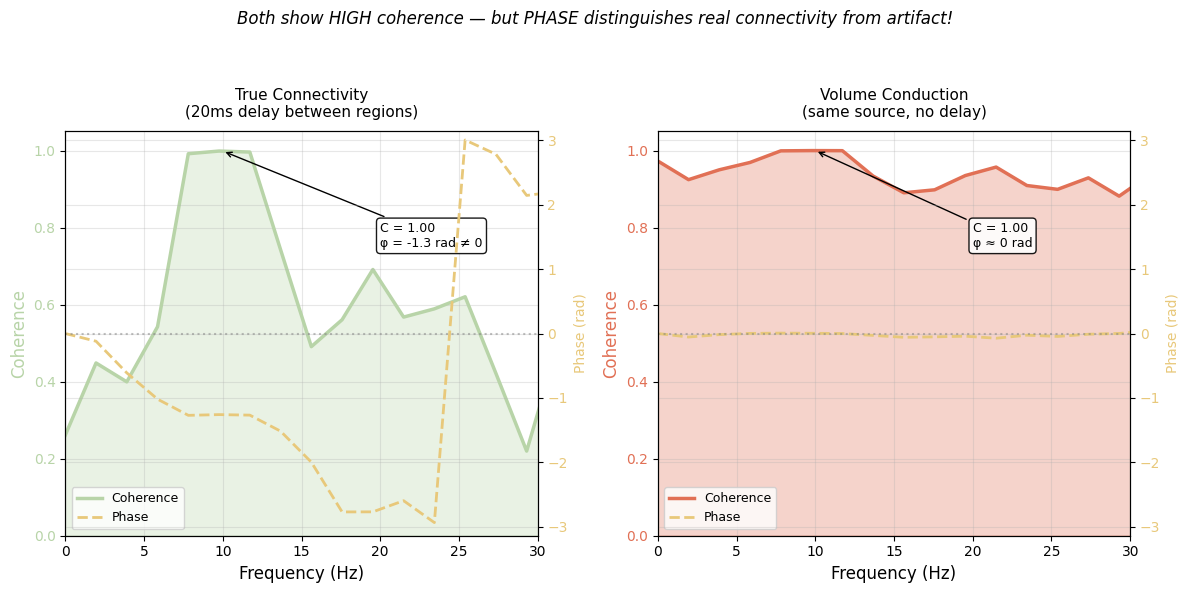

Key insight: Both scenarios have similar coherence, but PHASE reveals the truth!
• True connectivity: non-zero phase lag (signal propagation takes time)
• Volume conduction: zero phase lag (instantaneous electrical spread)


In [25]:
# =============================================================================
# Visualization 8: True Connectivity vs Volume Conduction
# =============================================================================
# 
# In EEG/hyperscanning, high coherence between two signals can arise from:
# 1. TRUE CONNECTIVITY: neural signal propagates from region A to B with a delay
#    → Phase varies with frequency (time delay = linear phase slope)
# 2. VOLUME CONDUCTION: same electrical source spreads instantaneously to both sensors
#    → Phase ≈ 0 at all frequencies (no delay = no phase shift)
#
# This distinction is critical: only true connectivity reflects real brain communication.
# Metrics like PLI and wPLI were developed specifically to ignore zero-lag connections.
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
np.random.seed(42)

fs = 500
n_samples = 2000
t = np.arange(n_samples) / fs

# =============================================================================
# Left: TRUE CONNECTIVITY
# Signal propagates from region A to region B with a 20ms delay
# =============================================================================
delay_ms = 20
delay_samples = int(delay_ms / 1000 * fs)

source_A = np.sin(2 * np.pi * 10 * t) + 0.3 * np.random.randn(n_samples)
source_B = np.roll(source_A, delay_samples) + 0.3 * np.random.randn(n_samples)

freqs_true, coh_true = compute_coherence(source_A, source_B, fs, nperseg=256)
_, csd_true = signal.csd(source_A, source_B, fs, nperseg=256)
phase_true = np.angle(csd_true)

# =============================================================================
# Right: VOLUME CONDUCTION
# Same source picked up by both sensors simultaneously (no delay)
# =============================================================================
common_source = np.sin(2 * np.pi * 10 * t) + 0.3 * np.random.randn(n_samples)
sensor_1 = common_source + 0.05 * np.random.randn(n_samples)
sensor_2 = 0.8 * common_source + 0.05 * np.random.randn(n_samples)

freqs_vc, coh_vc = compute_coherence(sensor_1, sensor_2, fs, nperseg=256)
_, csd_vc = signal.csd(sensor_1, sensor_2, fs, nperseg=256)
phase_vc = np.angle(csd_vc)

# =============================================================================
# Plotting
# =============================================================================

idx_10hz = np.argmin(np.abs(freqs_true - 10))

# --- Left panel: True Connectivity ---
ax1 = axes[0]
line_coh1, = ax1.plot(freqs_true, coh_true, color=COLORS['signal_3'], linewidth=2.5)
ax1.fill_between(freqs_true, 0, coh_true, alpha=0.3, color=COLORS['signal_3'])
ax1.set_xlim(0, 30)
ax1.set_ylim(0, 1.05)
ax1.set_xlabel('Frequency (Hz)', fontsize=12)
ax1.set_ylabel('Coherence', fontsize=12, color=COLORS['signal_3'])
ax1.tick_params(axis='y', labelcolor=COLORS['signal_3'])
ax1.set_title(f'True Connectivity\n({delay_ms}ms delay between regions)', fontsize=11, pad=10)

ax1_twin = ax1.twinx()
line_phase1, = ax1_twin.plot(freqs_true, phase_true, color=COLORS['signal_4'], 
                              linewidth=2, linestyle='--')
ax1_twin.set_ylabel('Phase (rad)', fontsize=10, color=COLORS['signal_4'])
ax1_twin.set_ylim(-np.pi, np.pi)
ax1_twin.tick_params(axis='y', labelcolor=COLORS['signal_4'])
ax1_twin.axhline(0, color='gray', linestyle=':', alpha=0.5)

ax1.legend([line_coh1, line_phase1], ['Coherence', 'Phase'], loc='lower left', fontsize=9)

ax1.annotate(f'C = {coh_true[idx_10hz]:.2f}\nφ = {phase_true[idx_10hz]:.1f} rad ≠ 0', 
             xy=(10, coh_true[idx_10hz]), xytext=(20, 0.75), fontsize=9,
             arrowprops=dict(arrowstyle='->', color='black'),
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# --- Right panel: Volume Conduction ---
ax2 = axes[1]
line_coh2, = ax2.plot(freqs_vc, coh_vc, color=COLORS['negative'], linewidth=2.5)
ax2.fill_between(freqs_vc, 0, coh_vc, alpha=0.3, color=COLORS['negative'])
ax2.set_xlim(0, 30)
ax2.set_ylim(0, 1.05)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Coherence', fontsize=12, color=COLORS['negative'])
ax2.tick_params(axis='y', labelcolor=COLORS['negative'])
ax2.set_title('Volume Conduction\n(same source, no delay)', fontsize=11, pad=10)

ax2_twin = ax2.twinx()
line_phase2, = ax2_twin.plot(freqs_vc, phase_vc, color=COLORS['signal_4'], 
                              linewidth=2, linestyle='--')
ax2_twin.set_ylabel('Phase (rad)', fontsize=10, color=COLORS['signal_4'])
ax2_twin.set_ylim(-np.pi, np.pi)
ax2_twin.tick_params(axis='y', labelcolor=COLORS['signal_4'])
ax2_twin.axhline(0, color='gray', linestyle=':', alpha=0.5)

ax2.legend([line_coh2, line_phase2], ['Coherence', 'Phase'], loc='lower left', fontsize=9)

ax2.annotate(f'C = {coh_vc[idx_10hz]:.2f}\nφ ≈ 0 rad', 
             xy=(10, coh_vc[idx_10hz]), xytext=(20, 0.75), fontsize=9,
             arrowprops=dict(arrowstyle='->', color='black'),
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

fig.suptitle('Both show HIGH coherence — but PHASE distinguishes real connectivity from artifact!', 
             fontsize=12, style='italic', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

print("Key insight: Both scenarios have similar coherence, but PHASE reveals the truth!")
print("• True connectivity: non-zero phase lag (signal propagation takes time)")
print("• Volume conduction: zero phase lag (instantaneous electrical spread)")

---

## Section 7: Band-Averaged Coherence

### Why Average Across Bands?

The full coherence spectrum can be complex to interpret. Often, we want a **single value** summarizing coherence in a frequency band:

| Band | Range | Associated Function |
|------|-------|---------------------|
| Delta | 1-4 Hz | Deep sleep, unconscious |
| Theta | 4-8 Hz | Memory, navigation |
| Alpha | 8-13 Hz | Relaxation, attention |
| Beta | 13-30 Hz | Active thinking, motor |
| Gamma | 30-100 Hz | Perception, binding |

### How to Compute Band Coherence

1. Compute full coherence spectrum
2. Select frequencies within the band
3. Average coherence values

### Caution

Averaging may obscure **narrow-band effects**. A sharp peak at 10 Hz might get diluted when averaging across 8-13 Hz. Always check the full spectrum first!

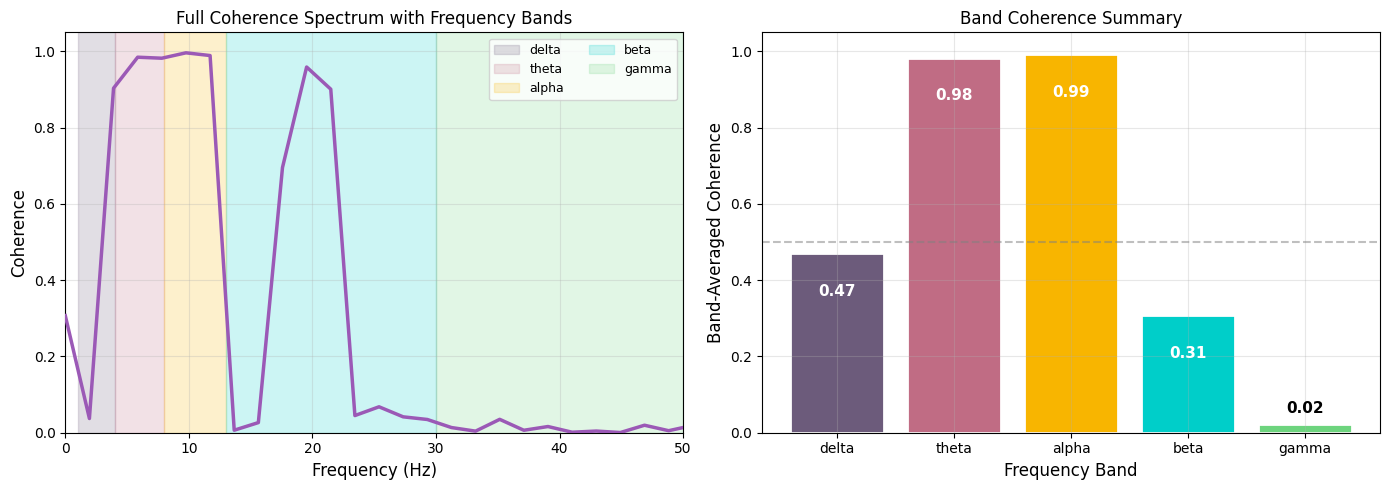

Band coherences: delta=0.47, theta=0.98, alpha=0.99, beta=0.31, gamma=0.02


In [26]:
# =============================================================================
# Visualization 9: Band-Averaged Coherence
# =============================================================================
#
# EEG analysis typically focuses on specific frequency bands with different
# functional significance:
#   - Delta (1-4 Hz): deep sleep, unconscious processes
#   - Theta (4-8 Hz): memory, emotional processing
#   - Alpha (8-13 Hz): relaxed wakefulness, inhibition
#   - Beta (13-30 Hz): active thinking, focus
#   - Gamma (30-50 Hz): perception, consciousness, binding
#
# Band-averaged coherence summarizes connectivity within each band.
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
np.random.seed(42)

fs = 500
n_samples = 4000
t = np.arange(n_samples) / fs

# Create signals with different coherence in different bands
shared_alpha = np.sin(2 * np.pi * 10 * t)
shared_theta = 0.5 * np.sin(2 * np.pi * 6 * t)
indep_beta_1 = 0.3 * np.sin(2 * np.pi * 20 * t + np.random.uniform(0, 2*np.pi))
indep_beta_2 = 0.3 * np.sin(2 * np.pi * 20 * t + np.random.uniform(0, 2*np.pi))

noise_1 = 0.3 * np.random.randn(n_samples)
noise_2 = 0.3 * np.random.randn(n_samples)

x = shared_alpha + shared_theta + indep_beta_1 + noise_1
y = shared_alpha + shared_theta + indep_beta_2 + noise_2

freqs, coh = compute_coherence(x, y, fs, nperseg=256)
band_coh = compute_all_band_coherence(x, y, fs, nperseg=256)

# =============================================================================
# Left panel: Full spectrum with frequency bands as vertical background regions
# =============================================================================
ax1 = axes[0]

bands = {
    'delta': (1, 4, COLORS['delta']),
    'theta': (4, 8, COLORS['theta']),
    'alpha': (8, 13, COLORS['alpha']),
    'beta': (13, 30, COLORS['beta']),
    'gamma': (30, 50, COLORS['gamma']),
}

# Draw bands as vertical spans FIRST (background)
for band_name, (f_low, f_high, color) in bands.items():
    ax1.axvspan(f_low, f_high, alpha=0.2, color=color, label=band_name)

# Draw coherence curve ON TOP
ax1.plot(freqs, coh, color=COLORS['high_sync'], linewidth=2.5, zorder=10)

ax1.set_xlim(0, 50)
ax1.set_ylim(0, 1.05)
ax1.set_xlabel('Frequency (Hz)', fontsize=12)
ax1.set_ylabel('Coherence', fontsize=12)
ax1.set_title('Full Coherence Spectrum with Frequency Bands', fontsize=12)
ax1.legend(loc='upper right', ncol=2, fontsize=9)

# =============================================================================
# Right panel: Bar chart of band coherences
# =============================================================================
ax2 = axes[1]
band_names = list(band_coh.keys())
band_values = list(band_coh.values())
band_colors = [COLORS[b] for b in band_names]

bars = ax2.bar(band_names, band_values, color=band_colors, edgecolor='white', linewidth=2)

# Add value labels INSIDE bars (to avoid title overlap)
for bar, val in zip(bars, band_values):
    label_y = bar.get_height() - 0.08 if bar.get_height() > 0.15 else bar.get_height() + 0.02
    label_color = 'white' if bar.get_height() > 0.15 else 'black'
    ax2.text(bar.get_x() + bar.get_width()/2, label_y, 
             f'{val:.2f}', ha='center', va='top' if bar.get_height() > 0.15 else 'bottom', 
             fontsize=11, fontweight='bold', color=label_color)

ax2.set_ylim(0, 1.05)
ax2.set_xlabel('Frequency Band', fontsize=12)
ax2.set_ylabel('Band-Averaged Coherence', fontsize=12)
ax2.set_title('Band Coherence Summary', fontsize=12)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Band coherences: {', '.join([f'{k}={v:.2f}' for k, v in band_coh.items()])}")

---

## Section 8: Coherence Matrix

### Scaling Up: Multi-Channel Analysis

With EEG, we typically have many channels (16, 32, 64, or more). We want to compute coherence for **all pairs** of channels.

### The Coherence Matrix

For n channels, the coherence matrix is:
- Size: n × n
- Symmetric: C_xy = C_yx
- Diagonal = 1 (self-coherence)
- Values: 0 to 1

### Example

For 8 channels:
- 8 × 8 = 64 matrix elements
- But only need (8 × 7) / 2 = 28 unique pairs
- Diagonal is always 1

### Functional Clusters

In practice, coherence matrices often reveal **functional clusters**: groups of channels that are highly coherent with each other but less coherent with other groups.

For example:
- **Frontal cluster**: Fp1, Fp2, F3, F4 (prefrontal and frontal electrodes)
- **Posterior cluster**: C3, C4, P3, P4 (central and parietal electrodes)

This structure reflects the underlying brain network organization.

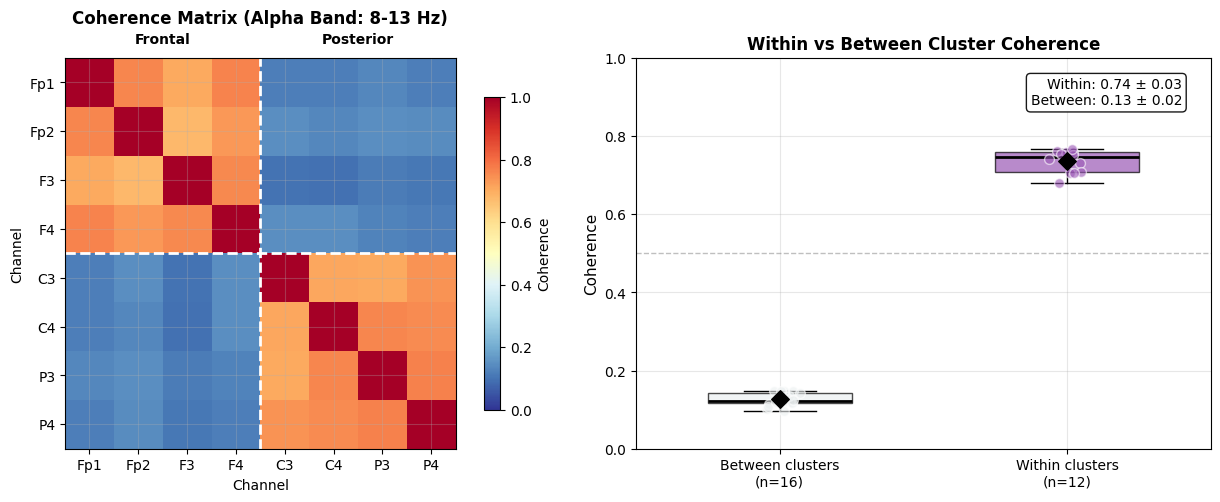


Coherence Matrix Statistics:
  Within-cluster coherence:  0.736 +/- 0.028
  Between-cluster coherence: 0.126 +/- 0.017


In [28]:
# =============================================================================
# Visualization 10: Coherence Matrix with Cluster Structure
# =============================================================================
#
# This visualization demonstrates how coherence matrices reveal functional
# organization in multi-channel EEG data.
#
# We simulate two clusters:
#   - Frontal cluster (Fp1, Fp2, F3, F4): channels sharing a common source
#   - Posterior cluster (C3, C4, P3, P4): channels sharing a different source
#
# Expected result: high coherence WITHIN clusters, low coherence BETWEEN clusters.
# =============================================================================

np.random.seed(42)

fs = 256
duration = 10
n_samples = int(fs * duration)
t = np.arange(n_samples) / fs

channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4']
n_channels = len(channels)

from scipy.signal import butter, filtfilt

def bandpass_filter(data: np.ndarray, lowcut: float, highcut: float, 
                    fs: float, order: int = 4) -> np.ndarray:
    """Apply bandpass filter."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Create two independent broadband sources (one per cluster) filtered to alpha band
source_frontal_raw = np.random.randn(n_samples)
source_posterior_raw = np.random.randn(n_samples)

source_frontal = bandpass_filter(source_frontal_raw, 8, 13, fs)
source_posterior = bandpass_filter(source_posterior_raw, 8, 13, fs)

source_frontal = source_frontal / np.std(source_frontal)
source_posterior = source_posterior / np.std(source_posterior)

frontal_channels = [0, 1, 2, 3]
posterior_channels = [4, 5, 6, 7]

# Build signals: shared source + individual noise
signals = np.zeros((n_channels, n_samples))
shared_weight = 0.7
noise_weight = 0.3

for i in range(n_channels):
    individual_noise_raw = np.random.randn(n_samples)
    individual_noise = bandpass_filter(individual_noise_raw, 8, 13, fs)
    individual_noise = individual_noise / np.std(individual_noise)
    
    if i in frontal_channels:
        signals[i] = shared_weight * source_frontal + noise_weight * individual_noise
    else:
        signals[i] = shared_weight * source_posterior + noise_weight * individual_noise

for i in range(n_channels):
    signals[i] = signals[i] / np.std(signals[i])

coherence_matrix = compute_coherence_matrix(
    signals, fs=fs,
    nperseg=512,
    band=(8, 13)
)

# =============================================================================
# Visualization
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# --- Left panel: Coherence matrix ---
im = axes[0].imshow(coherence_matrix, cmap='RdYlBu_r', vmin=0, vmax=1, aspect='equal')
axes[0].set_xticks(range(n_channels))
axes[0].set_yticks(range(n_channels))
axes[0].set_xticklabels(channels, fontsize=10)
axes[0].set_yticklabels(channels, fontsize=10)
axes[0].set_title('Coherence Matrix (Alpha Band: 8-13 Hz)', fontsize=12, fontweight='bold', pad=25)
axes[0].set_xlabel('Channel')
axes[0].set_ylabel('Channel')

cbar = plt.colorbar(im, ax=axes[0], shrink=0.8)
cbar.set_label('Coherence', fontsize=10)

# Cluster boundaries
axes[0].axhline(y=3.5, color='white', linewidth=2, linestyle='--')
axes[0].axvline(x=3.5, color='white', linewidth=2, linestyle='--')

# Cluster labels
axes[0].text(1.5, -0.8, 'Frontal', ha='center', fontsize=10, fontweight='bold')
axes[0].text(5.5, -0.8, 'Posterior', ha='center', fontsize=10, fontweight='bold')

# --- Right panel: Boxplot comparison ---
within_cluster = []
between_cluster = []

for i in range(n_channels):
    for j in range(i+1, n_channels):
        coh_val = coherence_matrix[i, j]
        same_cluster = (i in frontal_channels and j in frontal_channels) or \
                       (i in posterior_channels and j in posterior_channels)
        if same_cluster:
            within_cluster.append(coh_val)
        else:
            between_cluster.append(coh_val)

box_data = [between_cluster, within_cluster]
box_labels = [f'Between clusters\n(n={len(between_cluster)})', 
              f'Within clusters\n(n={len(within_cluster)})']
box_colors = [COLORS['low_sync'], COLORS['high_sync']]

bp = axes[1].boxplot(box_data, tick_labels=box_labels, patch_artist=True, widths=0.5)

for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)

# Add individual points
for i, (data, color) in enumerate(zip(box_data, box_colors)):
    x = np.random.normal(i + 1, 0.04, size=len(data))
    axes[1].scatter(x, data, alpha=0.6, color=color, edgecolor='white', s=50, zorder=10)

# Add mean markers
for i, data in enumerate(box_data):
    axes[1].scatter(i + 1, np.mean(data), marker='D', color='black', s=80, zorder=20, label='Mean' if i == 0 else '')

axes[1].set_ylabel('Coherence', fontsize=11)
axes[1].set_title('Within vs Between Cluster Coherence', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Add statistics as text
within_mean = np.mean(within_cluster)
between_mean = np.mean(between_cluster)
axes[1].text(0.95, 0.95, f'Within: {within_mean:.2f} ± {np.std(within_cluster):.2f}\n'
                         f'Between: {between_mean:.2f} ± {np.std(between_cluster):.2f}',
             transform=axes[1].transAxes, ha='right', va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

print(f"\nCoherence Matrix Statistics:")
print(f"  Within-cluster coherence:  {within_mean:.3f} +/- {np.std(within_cluster):.3f}")
print(f"  Between-cluster coherence: {between_mean:.3f} +/- {np.std(between_cluster):.3f}")

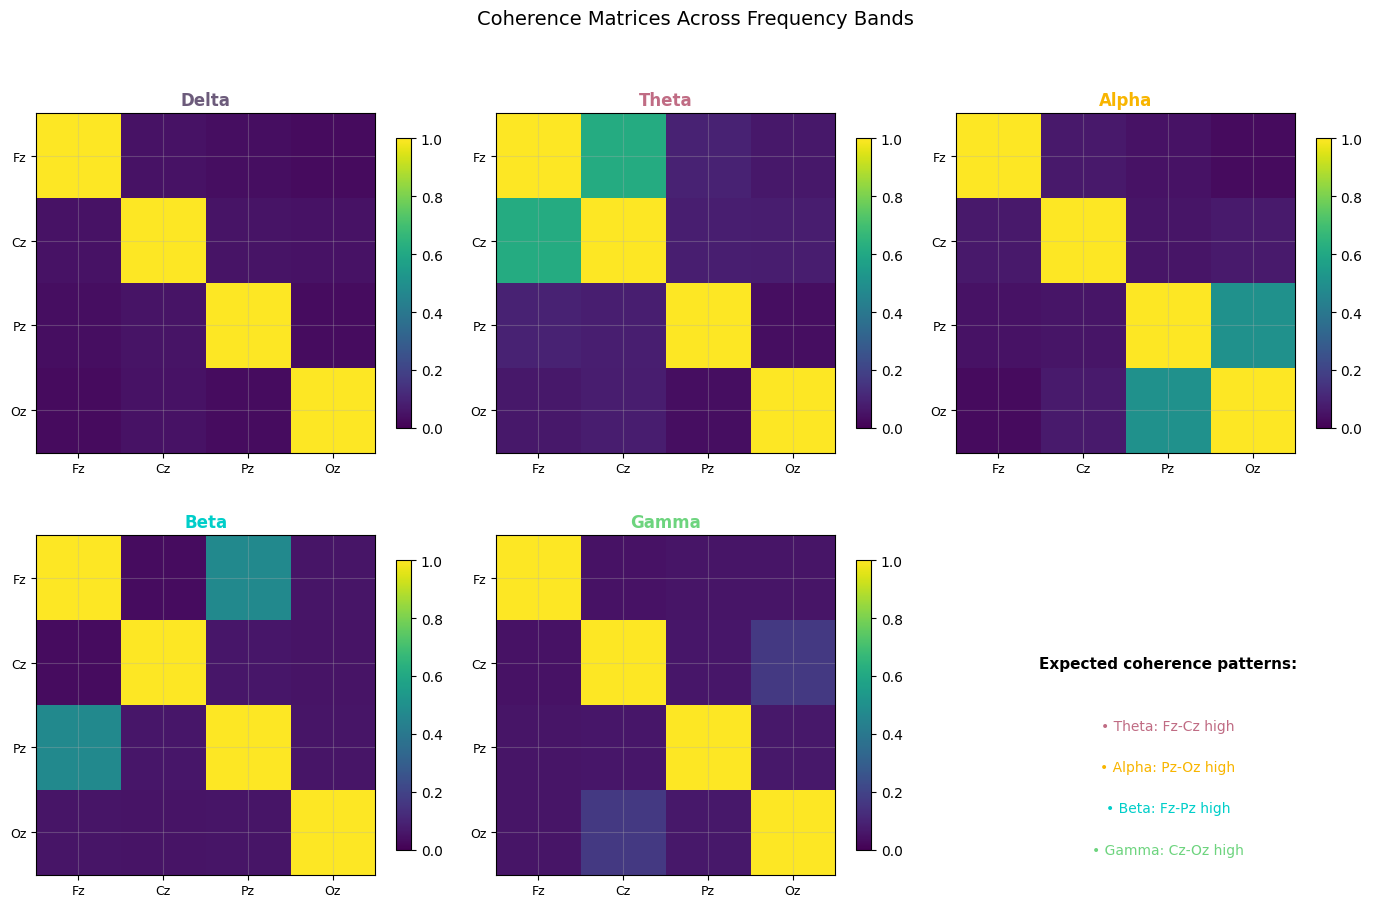


📊 This visualization shows how connectivity patterns differ across frequency bands!
   Each band reveals different functional connections between brain regions.


In [13]:
# =============================================================================
# Visualization 11: Coherence Matrices Across Frequency Bands
# =============================================================================
# Create signals with coherence in DIFFERENT frequency bands

np.random.seed(123)

# Parameters
fs = 256
duration = 10
n_samples = int(fs * duration)
t = np.arange(n_samples) / fs

channel_names = ['Fz', 'Cz', 'Pz', 'Oz']
n_channels = 4

# Strategy: Create pairs of channels that are coherent in different bands
# - Fz & Cz: coherent in theta (4-8 Hz)
# - Pz & Oz: coherent in alpha (8-13 Hz)
# - Fz & Pz: coherent in beta (13-30 Hz)
# - All pairs have some gamma noise

# Shared sources for each band
# For wider bands (beta, gamma), use MULTIPLE frequencies to cover more of the band
theta_source = np.sin(2 * np.pi * 6 * t)      # 6 Hz (theta: 4-8 Hz)
alpha_source = np.sin(2 * np.pi * 10 * t)     # 10 Hz (alpha: 8-13 Hz)

# Beta: use multiple frequencies to cover 13-30 Hz band
beta_source = (np.sin(2 * np.pi * 16 * t) + 
               np.sin(2 * np.pi * 20 * t) + 
               np.sin(2 * np.pi * 25 * t)) / 3

# Gamma: use multiple frequencies to cover 30-45 Hz band
gamma_source = (np.sin(2 * np.pi * 33 * t) + 
                np.sin(2 * np.pi * 38 * t) + 
                np.sin(2 * np.pi * 43 * t)) / 3

# Create signals with specific coherence patterns
# KEY: For high coherence, BOTH signals must share the SAME frequency component!
# Each signal = shared component(s) + individual noise
noise_level = 0.2

data = np.zeros((n_channels, n_samples))

# Fz: theta (shared with Cz) + beta (shared with Pz) + noise
data[0] = 0.8 * theta_source + 0.6 * beta_source + noise_level * np.random.randn(n_samples)

# Cz: theta (shared with Fz) + gamma (shared with Oz) + noise
data[1] = 0.8 * theta_source + 0.8 * gamma_source + noise_level * np.random.randn(n_samples)

# Pz: alpha (shared with Oz) + beta (shared with Fz) + noise
data[2] = 0.8 * alpha_source + 0.6 * beta_source + noise_level * np.random.randn(n_samples)

# Oz: alpha (shared with Pz) + gamma (shared with Cz) + noise
data[3] = 0.8 * alpha_source + 0.8 * gamma_source + noise_level * np.random.randn(n_samples)

# Compute coherence matrices for all bands
band_matrices = compute_coherence_matrix_bands(data, fs, nperseg=256)

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

band_list = ['delta', 'theta', 'alpha', 'beta', 'gamma']

for idx, band_name in enumerate(band_list):
    ax = axes[idx]
    matrix = band_matrices[band_name]
    
    im = ax.imshow(matrix, cmap='viridis', vmin=0, vmax=1, aspect='equal')
    ax.set_xticks(range(n_channels))
    ax.set_yticks(range(n_channels))
    ax.set_xticklabels(channel_names, fontsize=9)
    ax.set_yticklabels(channel_names, fontsize=9)
    ax.set_title(f'{band_name.capitalize()}', fontsize=12, 
                 color=COLORS[band_name], fontweight='bold')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, shrink=0.7)

# Remove last empty subplot and add explanation
axes[5].axis('off')
axes[5].text(0.5, 0.6, 'Expected coherence patterns:', 
             ha='center', va='center', fontsize=11, fontweight='bold',
             transform=axes[5].transAxes)
axes[5].text(0.5, 0.45, '• Theta: Fz-Cz high', 
             ha='center', va='center', fontsize=10, color=COLORS['theta'],
             transform=axes[5].transAxes)
axes[5].text(0.5, 0.35, '• Alpha: Pz-Oz high', 
             ha='center', va='center', fontsize=10, color=COLORS['alpha'],
             transform=axes[5].transAxes)
axes[5].text(0.5, 0.25, '• Beta: Fz-Pz high', 
             ha='center', va='center', fontsize=10, color=COLORS['beta'],
             transform=axes[5].transAxes)
axes[5].text(0.5, 0.15, '• Gamma: Cz-Oz high', 
             ha='center', va='center', fontsize=10, color=COLORS['gamma'],
             transform=axes[5].transAxes)

plt.suptitle('Coherence Matrices Across Frequency Bands', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 This visualization shows how connectivity patterns differ across frequency bands!")
print("   Each band reveals different functional connections between brain regions.")

---

## Section 9: Coherence for Hyperscanning

### Inter-Brain Coherence

In hyperscanning, we record from **two participants simultaneously**. This creates a unique opportunity:

**Between-brain coherence is NOT affected by volume conduction!**

Since the two brains are in separate heads, any coherence between them must reflect true coupling (or common external input).

### The Hyperscanning Coherence Structure

For a pair of participants:
- **Within-P1**: Coherence between P1's channels
- **Within-P2**: Coherence between P2's channels  
- **Between**: Coherence between P1 and P2 channels

### Research Findings

Inter-brain coherence has been found to:
- Increase during cooperation and social interaction
- Predict task performance in joint tasks
- Show frequency-specific patterns (theta for memory, alpha for attention)
- Distinguish real pairs from pseudo-pairs (shuffled data)

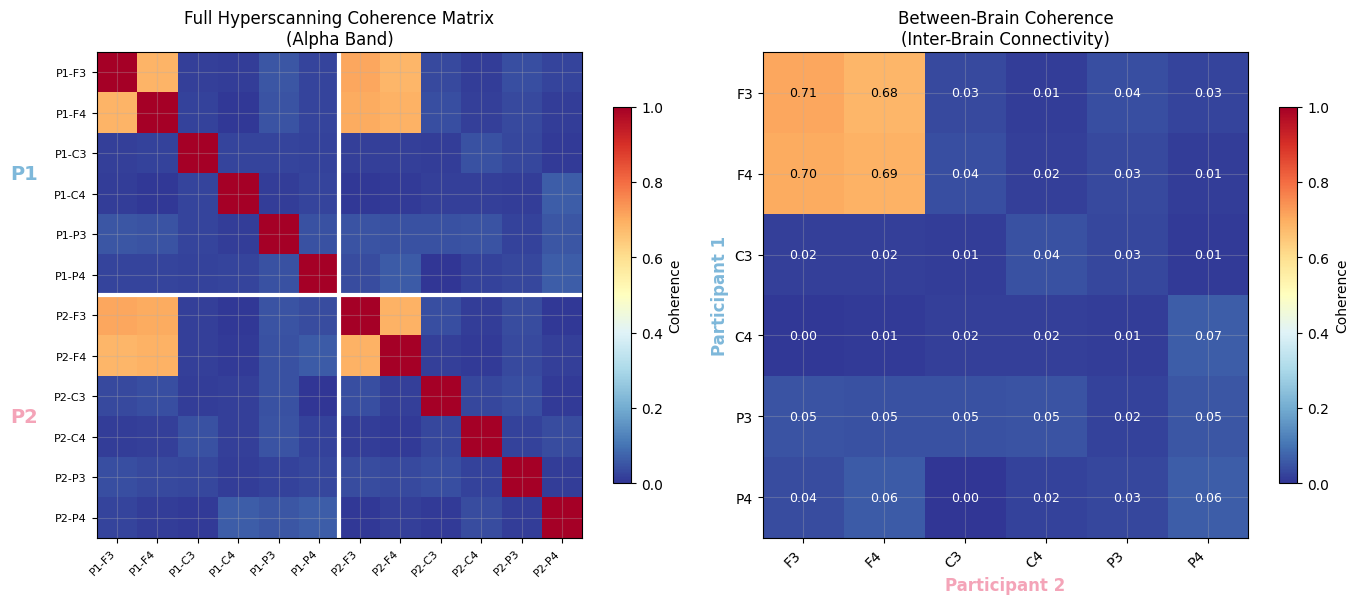

Mean within-P1 coherence: 0.071
Mean within-P2 coherence: 0.068
Mean between-brain coherence: 0.104
Between/within ratio: 1.501


In [31]:
# =============================================================================
# Visualization 12: Hyperscanning Coherence Matrix
# =============================================================================
#
# In hyperscanning, we record simultaneously from two participants.
# The coherence matrix has a block structure:
#   - Within-P1 block (top-left): coherence between P1's channels
#   - Within-P2 block (bottom-right): coherence between P2's channels
#   - Between-brain blocks (off-diagonal): inter-brain connectivity
#
# Key insight: Between-brain coherence cannot be caused by volume conduction
# since the two brains are in separate heads!
# =============================================================================

np.random.seed(42)
fs = 500
n_samples = 10000
t = np.arange(n_samples) / fs

n_ch_p1 = 6
n_ch_p2 = 6
ch_names_p1 = ['P1-F3', 'P1-F4', 'P1-C3', 'P1-C4', 'P1-P3', 'P1-P4']
ch_names_p2 = ['P2-F3', 'P2-F4', 'P2-C3', 'P2-C4', 'P2-P3', 'P2-P4']

# Simulated inter-brain synchronization at alpha (10 Hz) - frontal channels only
inter_brain_sync = np.sin(2 * np.pi * 10 * t)

# P1 data
data_p1 = np.zeros((n_ch_p1, n_samples))
for i in range(n_ch_p1):
    if i < 2:  # Frontal channels share inter-brain sync
        data_p1[i] = 0.8 * inter_brain_sync + 0.3 * np.random.randn(n_samples)
    else:
        data_p1[i] = np.random.randn(n_samples)

# P2 data
data_p2 = np.zeros((n_ch_p2, n_samples))
for i in range(n_ch_p2):
    if i < 2:  # Frontal channels share inter-brain sync
        data_p2[i] = 0.8 * inter_brain_sync + 0.3 * np.random.randn(n_samples)
    else:
        data_p2[i] = np.random.randn(n_samples)

hyper_coh = compute_coherence_hyperscanning(data_p1, data_p2, fs, band=(8, 13), nperseg=512)

# =============================================================================
# Visualization
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Left panel: Full matrix ---
ax1 = axes[0]
full_matrix = hyper_coh['full']
n_total = n_ch_p1 + n_ch_p2
all_ch_names = ch_names_p1 + ch_names_p2

im = ax1.imshow(full_matrix, cmap='RdYlBu_r', vmin=0, vmax=1, aspect='equal')
ax1.set_xticks(range(n_total))
ax1.set_yticks(range(n_total))
ax1.set_xticklabels(all_ch_names, fontsize=8, rotation=45, ha='right')
ax1.set_yticklabels(all_ch_names, fontsize=8)
ax1.set_title('Full Hyperscanning Coherence Matrix\n(Alpha Band)', fontsize=12)

# Block separators
ax1.axhline(n_ch_p1 - 0.5, color='white', linewidth=3)
ax1.axvline(n_ch_p1 - 0.5, color='white', linewidth=3)

# Block labels on the left side, outside the matrix
ax1.annotate('P1', xy=(-0.15, 0.75), xycoords='axes fraction', fontsize=14, fontweight='bold', 
             color=COLORS['signal_1'], va='center', ha='center')
ax1.annotate('P2', xy=(-0.15, 0.25), xycoords='axes fraction', fontsize=14, fontweight='bold', 
             color=COLORS['signal_2'], va='center', ha='center')

cbar1 = plt.colorbar(im, ax=ax1, shrink=0.7)
cbar1.set_label('Coherence', fontsize=10)

# --- Right panel: Between-brain matrix only ---
ax2 = axes[1]
between_matrix = hyper_coh['between']

im2 = ax2.imshow(between_matrix, cmap='RdYlBu_r', vmin=0, vmax=1, aspect='equal')
ax2.set_xticks(range(n_ch_p2))
ax2.set_yticks(range(n_ch_p1))
ax2.set_xticklabels([ch.replace('P2-', '') for ch in ch_names_p2], fontsize=10, rotation=45, ha='right')
ax2.set_yticklabels([ch.replace('P1-', '') for ch in ch_names_p1], fontsize=10)
ax2.set_xlabel('Participant 2', fontsize=12, color=COLORS['signal_2'], fontweight='bold')
ax2.set_ylabel('Participant 1', fontsize=12, color=COLORS['signal_1'], fontweight='bold')
ax2.set_title('Between-Brain Coherence\n(Inter-Brain Connectivity)', fontsize=12)

# Value annotations
for i in range(n_ch_p1):
    for j in range(n_ch_p2):
        val = between_matrix[i, j]
        color = 'white' if val < 0.5 else 'black'
        ax2.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=9, color=color)

cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.7)
cbar2.set_label('Coherence', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(left=0.08)  # Extra space for P1/P2 labels
plt.show()

stats = compute_global_coherence_hyperscanning(hyper_coh)
print(f"Mean within-P1 coherence: {stats['mean_within_p1']:.3f}")
print(f"Mean within-P2 coherence: {stats['mean_within_p2']:.3f}")
print(f"Mean between-brain coherence: {stats['mean_between']:.3f}")
print(f"Between/within ratio: {stats['ratio_between_within']:.3f}")

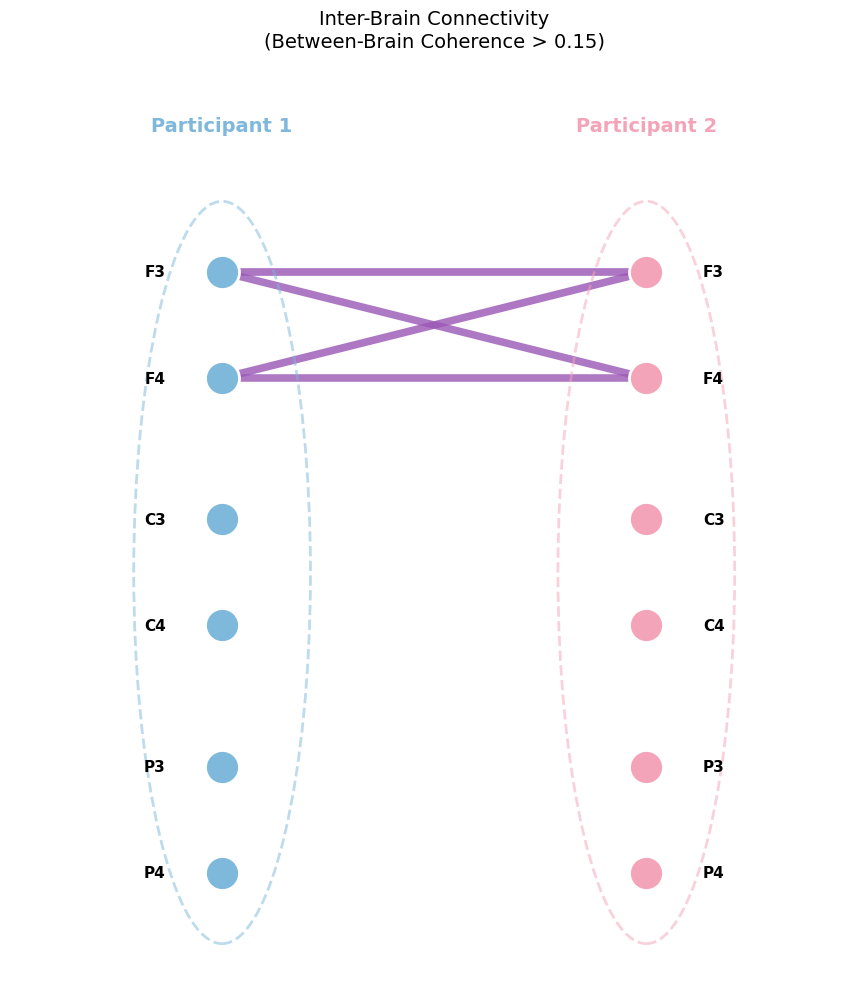

Lines show between-brain connections.
Frontal electrodes (F3, F4) show high inter-brain coherence — as expected from our simulation!


In [32]:
# =============================================================================
# Visualization 13: Circular Hyperscanning Plot
# =============================================================================
#
# This visualization shows inter-brain connectivity in a circular layout.
# Electrodes are positioned anatomically (frontal at top, parietal at bottom)
# so that homologous electrode pairs (e.g., P1-F3 ↔ P2-F3) are at the same height.
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 10))

# Electrode positions - anatomically organized
# P1 on the left, P2 on the right, mirrored layout
# Frontal (F) at top, Central (C) in middle, Parietal (P) at bottom

# Y positions (same for both participants)
y_positions = {
    'F3': 0.85, 'F4': 0.70,
    'C3': 0.50, 'C4': 0.35,
    'P3': 0.15, 'P4': 0.00
}

# X positions
x_p1 = 0.2  # Left side
x_p2 = 0.8  # Right side

# Store positions for drawing connections
positions_p1 = {}
positions_p2 = {}

# Draw nodes and labels for P1
for i, name in enumerate(ch_names_p1):
    electrode = name.split('-')[1]
    y = y_positions[electrode]
    positions_p1[i] = (x_p1, y)
    
    ax.scatter(x_p1, y, s=600, c=COLORS['signal_1'], zorder=5, 
               edgecolor='white', linewidth=2)
    ax.text(x_p1 - 0.08, y, electrode, ha='right', va='center', 
            fontsize=11, fontweight='bold')

# Draw nodes and labels for P2
for i, name in enumerate(ch_names_p2):
    electrode = name.split('-')[1]
    y = y_positions[electrode]
    positions_p2[i] = (x_p2, y)
    
    ax.scatter(x_p2, y, s=600, c=COLORS['signal_2'], zorder=5, 
               edgecolor='white', linewidth=2)
    ax.text(x_p2 + 0.08, y, electrode, ha='left', va='center', 
            fontsize=11, fontweight='bold')

# Draw between-brain connections
between_matrix = hyper_coh['between']
threshold = 0.15

for i in range(n_ch_p1):
    for j in range(n_ch_p2):
        coh_val = between_matrix[i, j]
        if coh_val > threshold:
            x1, y1 = positions_p1[i]
            x2, y2 = positions_p2[j]
            
            # Draw curved connection using Bezier-like curve
            n_points = 50
            t = np.linspace(0, 1, n_points)
            
            # Control point at center with slight vertical offset
            cx = 0.5
            cy = (y1 + y2) / 2
            
            # Quadratic Bezier curve
            x_curve = (1-t)**2 * x1 + 2*(1-t)*t * cx + t**2 * x2
            y_curve = (1-t)**2 * y1 + 2*(1-t)*t * cy + t**2 * y2
            
            alpha = 0.4 + 0.6 * coh_val
            linewidth = 2 + 5 * coh_val
            
            ax.plot(x_curve, y_curve, color=COLORS['high_sync'], 
                   alpha=alpha, linewidth=linewidth, zorder=1)

# Participant labels
ax.text(x_p1, 1.05, 'Participant 1', ha='center', fontsize=14, 
        fontweight='bold', color=COLORS['signal_1'])
ax.text(x_p2, 1.05, 'Participant 2', ha='center', fontsize=14, 
        fontweight='bold', color=COLORS['signal_2'])

# Brain outline (simple ellipses)
from matplotlib.patches import Ellipse
ellipse_p1 = Ellipse((x_p1, 0.425), 0.25, 1.05, fill=False, 
                      edgecolor=COLORS['signal_1'], linewidth=2, linestyle='--', alpha=0.5)
ellipse_p2 = Ellipse((x_p2, 0.425), 0.25, 1.05, fill=False, 
                      edgecolor=COLORS['signal_2'], linewidth=2, linestyle='--', alpha=0.5)
ax.add_patch(ellipse_p1)
ax.add_patch(ellipse_p2)

# Configure axes
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.15, 1.15)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Inter-Brain Connectivity\n(Between-Brain Coherence > 0.15)', fontsize=14, pad=10)

plt.tight_layout()
plt.show()

print("Lines show between-brain connections.")
print("Frontal electrodes (F3, F4) show high inter-brain coherence — as expected from our simulation!")

---

## Section 10: Statistical Significance for Coherence

**Estimated Time: 5 minutes**

A critical question when analyzing coherence: **Is this coherence value statistically significant?**

### The Problem with Raw Coherence

Even for completely independent signals, coherence is never exactly zero due to:
- **Finite sample size**: Limited data means estimation noise
- **Spectral leakage**: FFT artifacts create spurious correlations
- **Segment averaging**: Random fluctuations don't perfectly cancel

### Determining Significance

**1. Analytical Threshold**

For a coherence estimate from $N$ segments, the theoretical significance threshold at confidence level $\alpha$ is:

$$C_{threshold} = 1 - \alpha^{1/(N-1)}$$

**2. Surrogate Methods**

More robust approach:
1. Shuffle one signal (break temporal relationship)
2. Compute coherence of shuffled pair
3. Repeat many times to build null distribution
4. Compare original coherence to null distribution

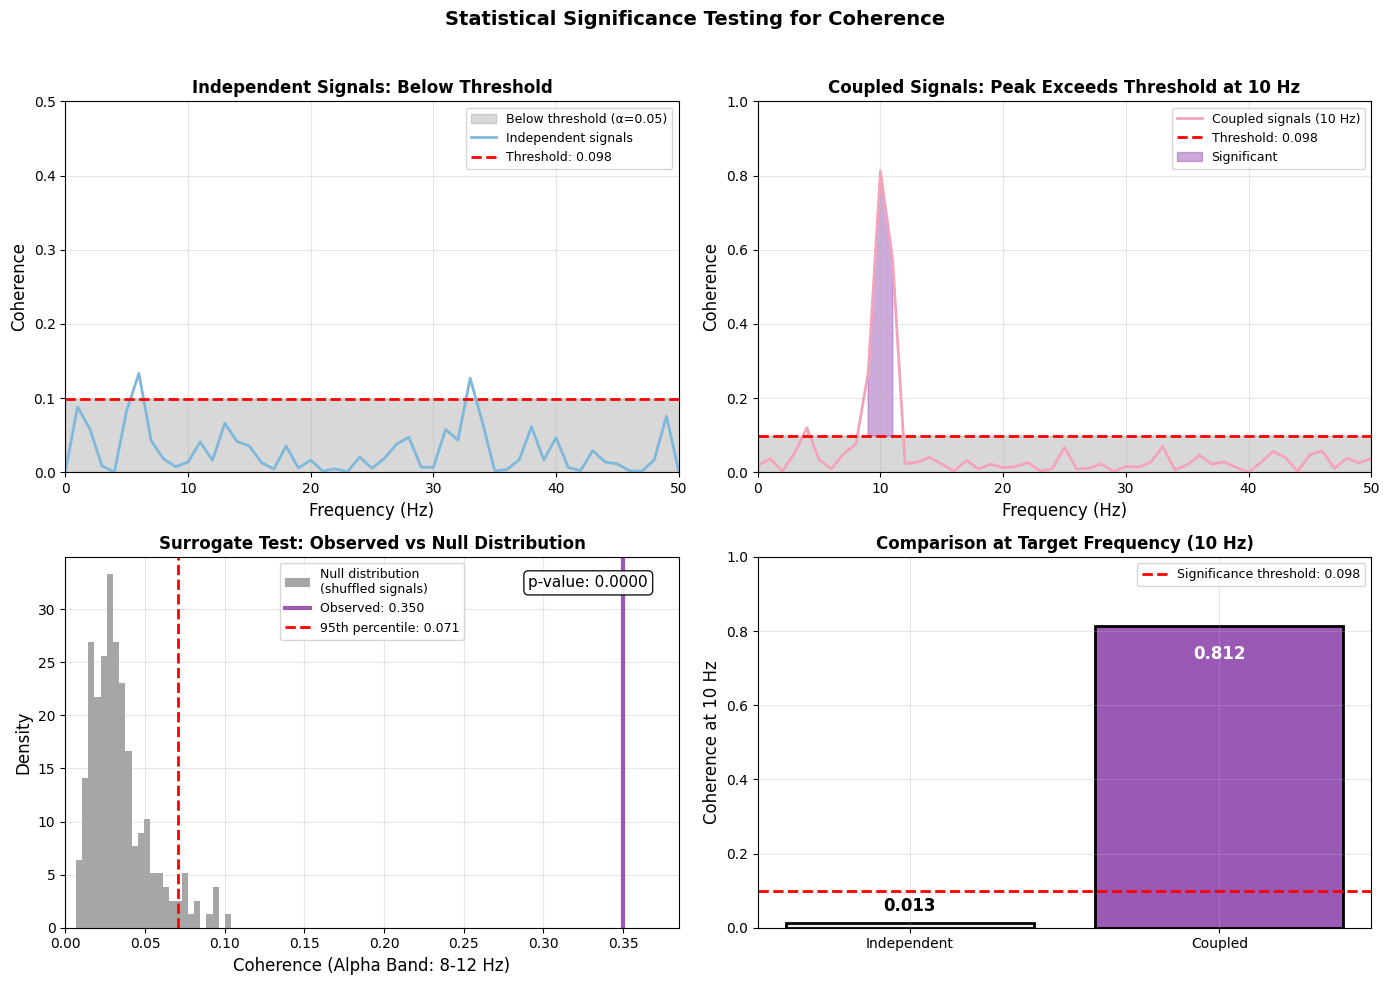

Analytical threshold (30 segments, α=0.05): 0.0981
Surrogate test p-value (alpha band): 0.0000
Significant (p < 0.05): True


In [34]:
# =============================================================================
# Visualization 14: Significance Testing Methods
# =============================================================================
#
# Two approaches to determine if coherence is statistically significant:
#
# 1. ANALYTICAL THRESHOLD: Based on the number of segments used in the estimate
#    C_threshold = 1 - alpha^(1/(N-1))
#
# 2. SURROGATE METHODS: Shuffle one signal to break temporal coupling,
#    compute coherence, repeat many times to build a null distribution.
# =============================================================================

from src.coherence import coherence_significance_threshold, coherence_surrogate_test
from src.coherence import compute_coherence, compute_band_coherence

fs = 256
n_samples = 4000
t = np.arange(n_samples) / fs

np.random.seed(42)

# Case 1: Independent signals (null hypothesis)
indep_1 = np.random.randn(n_samples)
indep_2 = np.random.randn(n_samples)

# Case 2: Weakly coupled signals at 10 Hz
shared = np.sin(2 * np.pi * 10 * t)
coupled_1 = 0.3 * shared + 0.7 * np.random.randn(n_samples)
coupled_2 = 0.3 * shared + 0.7 * np.random.randn(n_samples)

nperseg = 256
noverlap = 128

freqs, coh_indep = compute_coherence(indep_1, indep_2, fs, nperseg, noverlap)
_, coh_coupled = compute_coherence(coupled_1, coupled_2, fs, nperseg, noverlap)

# Analytical threshold
n_segments = int((n_samples - noverlap) / (nperseg - noverlap))
alpha = 0.05
threshold_analytical = coherence_significance_threshold(n_segments, alpha)

# Surrogate test for alpha band
surrogate_result = coherence_surrogate_test(
    coupled_1, coupled_2, fs, 
    band=(8, 12),
    n_surrogates=200,
    nperseg=nperseg,
    seed=42
)

# Build null distribution for plotting
np.random.seed(123)
null_distribution = np.zeros(200)
y_shuffled = coupled_2.copy()
for i in range(200):
    np.random.shuffle(y_shuffled)
    null_distribution[i] = compute_band_coherence(coupled_1, y_shuffled, fs, (8, 12), nperseg)

# =============================================================================
# Plot
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Top left: Independent signals ---
ax = axes[0, 0]
ax.fill_between(freqs, 0, threshold_analytical, alpha=0.3, color='gray', 
                label=f'Below threshold (α={alpha})')
ax.plot(freqs, coh_indep, color=COLORS['signal_1'], linewidth=2, label='Independent signals')
ax.axhline(threshold_analytical, color='red', linestyle='--', linewidth=2, 
           label=f'Threshold: {threshold_analytical:.3f}')
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Coherence', fontsize=12)
ax.set_title('Independent Signals: Below Threshold', fontsize=12, fontweight='bold')
ax.set_xlim(0, 50)
ax.set_ylim(0, 0.5)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# --- Top right: Coupled signals ---
ax = axes[0, 1]
ax.fill_between(freqs, 0, threshold_analytical, alpha=0.3, color='gray')
ax.plot(freqs, coh_coupled, color=COLORS['signal_2'], linewidth=2, label='Coupled signals (10 Hz)')
ax.axhline(threshold_analytical, color='red', linestyle='--', linewidth=2, 
           label=f'Threshold: {threshold_analytical:.3f}')

mask_sig = coh_coupled > threshold_analytical
ax.fill_between(freqs, threshold_analytical, coh_coupled, where=mask_sig, 
                alpha=0.5, color=COLORS['high_sync'], label='Significant')

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Coherence', fontsize=12)
ax.set_title('Coupled Signals: Peak Exceeds Threshold at 10 Hz', fontsize=12, fontweight='bold')
ax.set_xlim(0, 50)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# --- Bottom left: Surrogate distribution ---
ax = axes[1, 0]
observed_coherence = surrogate_result['observed']

# Adjust x-axis to show both distribution and observed value clearly
x_max = max(null_distribution.max(), observed_coherence) * 1.1

ax.hist(null_distribution, bins=25, density=True, alpha=0.7, color='gray', 
        label='Null distribution\n(shuffled signals)')
ax.axvline(observed_coherence, color=COLORS['high_sync'], linewidth=3, 
           label=f'Observed: {observed_coherence:.3f}')
ax.axvline(surrogate_result['threshold_95'], color='red', linestyle='--', linewidth=2, 
           label=f'95th percentile: {surrogate_result["threshold_95"]:.3f}')

# Add annotation for p-value
ax.text(0.95, 0.95, f'p-value: {surrogate_result["pvalue"]:.4f}', 
        transform=ax.transAxes, ha='right', va='top', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

ax.set_xlabel('Coherence (Alpha Band: 8-12 Hz)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Surrogate Test: Observed vs Null Distribution', fontsize=12, fontweight='bold')
ax.set_xlim(0, x_max)
ax.legend(loc='upper center', fontsize=9)
ax.grid(True, alpha=0.3)

# --- Bottom right: Summary at 10 Hz ---
ax = axes[1, 1]

# Compare both signals at the SAME frequency (10 Hz) for fair comparison
idx_10hz = np.argmin(np.abs(freqs - 10))
coherence_at_10hz = [coh_indep[idx_10hz], coh_coupled[idx_10hz]]
conditions = ['Independent', 'Coupled']
colors_bar = [COLORS['low_sync'], COLORS['high_sync']]

bars = ax.bar(conditions, coherence_at_10hz, color=colors_bar, edgecolor='black', linewidth=2)
ax.axhline(threshold_analytical, color='red', linestyle='--', linewidth=2, 
           label=f'Significance threshold: {threshold_analytical:.3f}')

# Value labels inside bars
for bar, val in zip(bars, coherence_at_10hz):
    label_y = val - 0.05 if val > 0.15 else val + 0.02
    label_color = 'white' if val > 0.15 else 'black'
    va = 'top' if val > 0.15 else 'bottom'
    ax.text(bar.get_x() + bar.get_width()/2, label_y, f'{val:.3f}', 
            ha='center', va=va, fontsize=12, fontweight='bold', color=label_color)

ax.set_ylabel('Coherence at 10 Hz', fontsize=12)
ax.set_title('Comparison at Target Frequency (10 Hz)', fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Statistical Significance Testing for Coherence', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(f"Analytical threshold ({n_segments} segments, α=0.05): {threshold_analytical:.4f}")
print(f"Surrogate test p-value (alpha band): {surrogate_result['pvalue']:.4f}")
print(f"Significant (p < 0.05): {surrogate_result['pvalue'] < 0.05}")

---

## Section 11: Comparison with scipy.signal.coherence

### Validating Our Implementation

While we implemented coherence from scratch for educational purposes, it's important to validate our implementation against the standard library. `scipy.signal.coherence` is the reference implementation used in production code.

**Why implement ourselves?**
- **Understanding**: Building it helps you understand what's happening
- **Flexibility**: Easy to extend for custom metrics
- **Foundation**: Basis for imaginary coherence and other variants

**When to use scipy?**
- Production code where speed matters
- When you need a validated, tested implementation

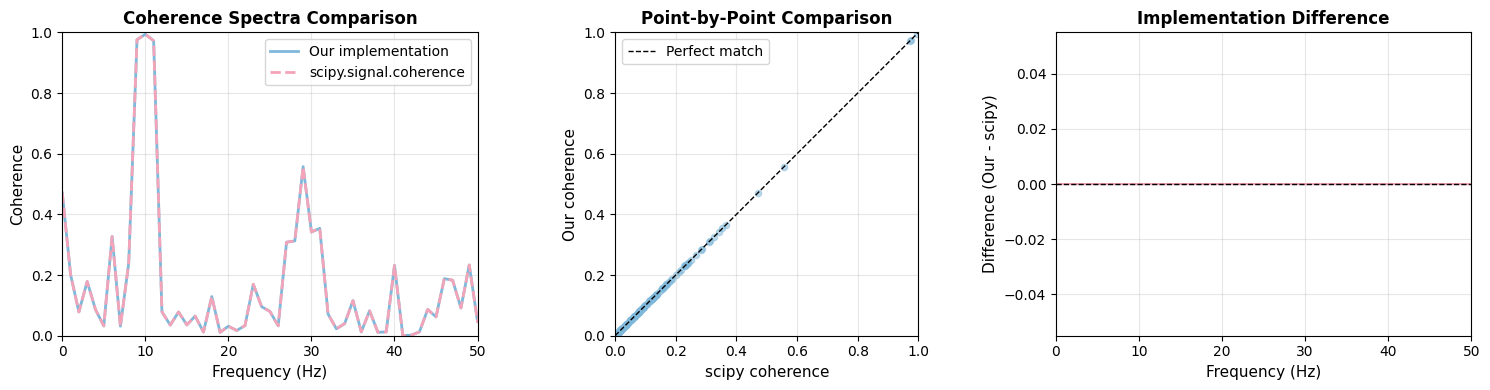


📊 Implementation Comparison:
   Maximum absolute difference: 0.00e+00
   Correlation between implementations: 1.000000

✅ Implementations match!


In [36]:
# =============================================================================
# Visualization 15: Comparison with scipy.signal.coherence
# =============================================================================

np.random.seed(42)

# Create test signals
fs = 256
duration = 5
n_samples = int(fs * duration)
t = np.arange(n_samples) / fs

# Signals with known coherence
shared = np.sin(2 * np.pi * 10 * t)
x = shared + 0.3 * np.random.randn(n_samples)
y = shared + 0.5 * np.random.randn(n_samples)

# Compare implementations
comparison = compare_with_scipy_coherence(x, y, fs, nperseg=256)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Left: Both coherence spectra
freqs_our, coh_our = compute_coherence(x, y, fs, nperseg=256)
from scipy.signal import coherence as scipy_coherence
freqs_scipy, coh_scipy = scipy_coherence(x, y, fs=fs, nperseg=256)

axes[0].plot(freqs_our, coh_our, color=COLORS['signal_1'], linewidth=2, 
             label='Our implementation')
axes[0].plot(freqs_scipy, coh_scipy, '--', color=COLORS['signal_2'], linewidth=2, 
             label='scipy.signal.coherence')
axes[0].set_xlabel('Frequency (Hz)', fontsize=11)
axes[0].set_ylabel('Coherence', fontsize=11)
axes[0].set_title('Coherence Spectra Comparison', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, 50)
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3)

# Middle: Scatter plot
axes[1].scatter(coh_scipy, coh_our, alpha=0.5, color=COLORS['signal_1'], s=20)
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect match')
axes[1].set_xlabel('scipy coherence', fontsize=11)
axes[1].set_ylabel('Our coherence', fontsize=11)
axes[1].set_title('Point-by-Point Comparison', fontsize=12, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_aspect('equal')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Right: Difference
diff = coh_our - coh_scipy
axes[2].plot(freqs_our, diff, color=COLORS['signal_2'], linewidth=1.5)
axes[2].axhline(0, color='black', linestyle='--', linewidth=1)
axes[2].fill_between(freqs_our, diff, alpha=0.3, color=COLORS['signal_2'])
axes[2].set_xlabel('Frequency (Hz)', fontsize=11)
axes[2].set_ylabel('Difference (Our - scipy)', fontsize=11)
axes[2].set_title('Implementation Difference', fontsize=12, fontweight='bold')
axes[2].set_xlim(0, 50)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n📊 Implementation Comparison:")
print(f"   Maximum absolute difference: {comparison['max_difference']:.2e}")
print(f"   Correlation between implementations: {comparison['correlation']:.6f}")
print(f"\n✅ Implementations match!" if comparison['max_difference'] < 1e-10 else 
      f"\n⚠️ Small numerical differences (expected with different computation order)")

---

## Section 12: Hands-On Exercises

Practice applying coherence analysis with these exercises. Solutions are provided at the end.

In [ ]:
# =============================================================================
# Exercise 1: Basic Coherence
# =============================================================================
# Generate two signals with a shared 10 Hz component and independent noise.
# Compute the coherence spectrum and identify the peak at 10 Hz.
# Then vary the noise level and observe how it affects coherence.

# Your code here:
# fs = 256
# duration = 5
# ...

In [ ]:
# Solution (uncomment to see):
# -----------------------------
# np.random.seed(42)
# fs = 256
# duration = 5
# n_samples = int(fs * duration)
# t = np.arange(n_samples) / fs
# 
# shared_10hz = np.sin(2 * np.pi * 10 * t)
# 
# noise_levels = [0.1, 0.5, 1.0, 2.0]
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# 
# for ax, noise in zip(axes.flatten(), noise_levels):
#     x = shared_10hz + noise * np.random.randn(n_samples)
#     y = shared_10hz + noise * np.random.randn(n_samples)
#     freqs, coh = compute_coherence(x, y, fs, nperseg=256)
#     ax.plot(freqs, coh, color=COLORS['signal_1'])
#     ax.axvline(10, color='red', linestyle='--', alpha=0.5)
#     ax.set_xlim(0, 50)
#     ax.set_ylim(0, 1)
#     ax.set_xlabel('Frequency (Hz)')
#     ax.set_ylabel('Coherence')
#     ax.set_title(f'Noise level = {noise}')
#     ax.grid(True, alpha=0.3)
# 
# plt.tight_layout()
# plt.show()

In [ ]:
# =============================================================================
# Exercise 2: Phase Effects on Coherence
# =============================================================================
# Create two 10 Hz signals with different phase shifts (0°, 45°, 90°, 180°).
# Compute coherence for each case and verify that coherence is unchanged
# by phase shift (coherence only measures magnitude of relationship).

# Your code here:

In [ ]:
# Solution (uncomment to see):
# -----------------------------
# np.random.seed(42)
# fs = 256
# duration = 5
# n_samples = int(fs * duration)
# t = np.arange(n_samples) / fs
# 
# x = np.sin(2 * np.pi * 10 * t) + 0.2 * np.random.randn(n_samples)
# phase_shifts = [0, 45, 90, 180]
# 
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# 
# for ax, phase in zip(axes.flatten(), phase_shifts):
#     phase_rad = np.deg2rad(phase)
#     y = np.sin(2 * np.pi * 10 * t + phase_rad) + 0.2 * np.random.randn(n_samples)
#     freqs, coh = compute_coherence(x, y, fs, nperseg=256)
#     
#     # Find coherence at 10 Hz
#     idx_10hz = np.argmin(np.abs(freqs - 10))
#     coh_at_10hz = coh[idx_10hz]
#     
#     ax.plot(freqs, coh, color=COLORS['signal_1'])
#     ax.axvline(10, color='red', linestyle='--', alpha=0.5)
#     ax.set_xlim(0, 50)
#     ax.set_ylim(0, 1)
#     ax.set_xlabel('Frequency (Hz)')
#     ax.set_ylabel('Coherence')
#     ax.set_title(f'Phase shift = {phase}° | Coh@10Hz = {coh_at_10hz:.3f}')
#     ax.grid(True, alpha=0.3)
# 
# plt.suptitle('Coherence is INDEPENDENT of phase shift!', fontsize=14, fontweight='bold')
# plt.tight_layout()
# plt.show()

In [ ]:
# =============================================================================
# Exercise 3: Volume Conduction Simulation
# =============================================================================
# Simulate a single source that appears at two electrodes (volume conduction).
# Compute coherence between the electrodes - it should be very high!
# This demonstrates spurious connectivity from volume conduction.
# Save this example for comparison with imaginary coherence (F02).

# Your code here:

In [ ]:
# Solution (uncomment to see):
# -----------------------------
# np.random.seed(42)
# fs = 256
# duration = 5
# n_samples = int(fs * duration)
# t = np.arange(n_samples) / fs
# 
# # Single neural source with alpha activity
# source = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 20 * t)
# source += 0.1 * np.random.randn(n_samples)
# 
# # Both electrodes pick up the same source (volume conduction)
# # with only slightly different gains and tiny sensor noise
# electrode_1 = 1.0 * source + 0.01 * np.random.randn(n_samples)
# electrode_2 = 0.8 * source + 0.01 * np.random.randn(n_samples)
# 
# freqs, coh = compute_coherence(electrode_1, electrode_2, fs, nperseg=256)
# 
# fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# 
# # Time series
# axes[0].plot(t[:500], electrode_1[:500], label='Electrode 1', color=COLORS['signal_1'])
# axes[0].plot(t[:500], electrode_2[:500], label='Electrode 2', color=COLORS['signal_2'], alpha=0.7)
# axes[0].set_xlabel('Time (s)')
# axes[0].set_ylabel('Amplitude')
# axes[0].set_title('Signals (nearly identical due to volume conduction)')
# axes[0].legend()
# 
# # Coherence
# axes[1].plot(freqs, coh, color=COLORS['signal_1'], linewidth=2)
# axes[1].axhline(0.99, color='red', linestyle='--', label='Near-perfect coherence')
# axes[1].set_xlim(0, 50)
# axes[1].set_ylim(0, 1.05)
# axes[1].set_xlabel('Frequency (Hz)')
# axes[1].set_ylabel('Coherence')
# axes[1].set_title('Spurious coherence from volume conduction!')
# axes[1].legend()
# 
# plt.tight_layout()
# plt.show()
# 
# print("⚠️ This high coherence is NOT true connectivity - it's volume conduction!")

In [ ]:
# =============================================================================
# Exercise 4: Band Coherence Analysis
# =============================================================================
# Generate multi-frequency signals with:
# - High coupling in alpha (8-13 Hz)
# - Low coupling in beta (13-30 Hz)
# - Medium coupling in theta (4-8 Hz)
# Compute band-averaged coherence and verify the pattern matches your design.

# Your code here:

In [ ]:
# Solution (uncomment to see):
# -----------------------------
# np.random.seed(42)
# fs = 256
# duration = 8
# n_samples = int(fs * duration)
# t = np.arange(n_samples) / fs
# 
# # Shared components at different levels
# theta_shared = 0.5 * np.sin(2 * np.pi * 6 * t)   # Medium coupling
# alpha_shared = 1.0 * np.sin(2 * np.pi * 10 * t)  # High coupling
# beta_indep_1 = np.sin(2 * np.pi * 20 * t)        # Independent (low coupling)
# beta_indep_2 = np.sin(2 * np.pi * 21 * t)        # Different frequency
# 
# x = theta_shared + alpha_shared + beta_indep_1 + 0.3 * np.random.randn(n_samples)
# y = theta_shared + alpha_shared + beta_indep_2 + 0.3 * np.random.randn(n_samples)
# 
# # Compute band coherence
# band_coh = compute_all_band_coherence(x, y, fs, nperseg=256)
# 
# # Visualize
# fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# 
# # Full spectrum
# freqs, coh = compute_coherence(x, y, fs, nperseg=256)
# axes[0].plot(freqs, coh, color=COLORS['signal_1'])
# axes[0].axvspan(4, 8, alpha=0.2, color=COLORS['theta'], label='Theta')
# axes[0].axvspan(8, 13, alpha=0.2, color=COLORS['alpha'], label='Alpha')
# axes[0].axvspan(13, 30, alpha=0.2, color=COLORS['beta'], label='Beta')
# axes[0].set_xlim(0, 40)
# axes[0].set_ylim(0, 1)
# axes[0].set_xlabel('Frequency (Hz)')
# axes[0].set_ylabel('Coherence')
# axes[0].set_title('Full Coherence Spectrum')
# axes[0].legend()
# 
# # Band bars
# bands = ['theta', 'alpha', 'beta']
# colors = [COLORS['theta'], COLORS['alpha'], COLORS['beta']]
# values = [band_coh['theta'], band_coh['alpha'], band_coh['beta']]
# axes[1].bar(bands, values, color=colors, edgecolor='black')
# axes[1].set_ylim(0, 1)
# axes[1].set_ylabel('Band-Averaged Coherence')
# axes[1].set_title('Expected: Alpha > Theta > Beta')
# 
# plt.tight_layout()
# plt.show()
# 
# print(f"Theta: {band_coh['theta']:.3f} (medium)")
# print(f"Alpha: {band_coh['alpha']:.3f} (high)")
# print(f"Beta: {band_coh['beta']:.3f} (low)")

In [ ]:
# =============================================================================
# Exercise 5: Coherence Matrix with Cluster Structure
# =============================================================================
# Create 8-channel simulated data where:
# - Channels 1-4 (cluster 1) share some activity
# - Channels 5-8 (cluster 2) share different activity
# - Little connection between clusters
# Compute and visualize the coherence matrix. Do you see the cluster structure?

# Your code here:

In [ ]:
# Solution (uncomment to see):
# -----------------------------
# np.random.seed(42)
# fs = 256
# duration = 10
# n_samples = int(fs * duration)
# t = np.arange(n_samples) / fs
# 
# # Filter function for broadband sources
# from scipy.signal import butter, filtfilt
# def bp_filter(data, low, high, fs):
#     b, a = butter(4, [low/(fs/2), high/(fs/2)], btype='band')
#     return filtfilt(b, a, data)
# 
# # Cluster sources (broadband in alpha)
# source_1 = bp_filter(np.random.randn(n_samples), 8, 13, fs)
# source_2 = bp_filter(np.random.randn(n_samples), 8, 13, fs)
# 
# # Build 8 channels
# data = np.zeros((8, n_samples))
# for i in range(4):
#     noise = bp_filter(np.random.randn(n_samples), 8, 13, fs)
#     data[i] = 0.7 * source_1 + 0.3 * noise
# for i in range(4, 8):
#     noise = bp_filter(np.random.randn(n_samples), 8, 13, fs)
#     data[i] = 0.7 * source_2 + 0.3 * noise
# 
# # Compute coherence matrix
# coh_matrix = compute_coherence_matrix(data, fs, band=(8, 13), nperseg=512)
# 
# # Visualize
# plt.figure(figsize=(8, 6))
# im = plt.imshow(coh_matrix, cmap='viridis', vmin=0, vmax=1)
# plt.colorbar(im, label='Coherence')
# plt.xticks(range(8), [f'Ch{i+1}' for i in range(8)])
# plt.yticks(range(8), [f'Ch{i+1}' for i in range(8)])
# plt.axhline(3.5, color='white', linestyle='--', linewidth=2)
# plt.axvline(3.5, color='white', linestyle='--', linewidth=2)
# plt.title('Coherence Matrix - Can you see the two clusters?')
# plt.show()

In [ ]:
# =============================================================================
# Exercise 6: Hyperscanning Coherence
# =============================================================================
# Simulate two "participants" (4 channels each).
# Add inter-brain coherence between specific channel pairs (e.g., Fz_P1 - Fz_P2).
# Compute full hyperscanning coherence and extract the between-brain matrix.

# Your code here:

In [ ]:
# Solution (uncomment to see):
# -----------------------------
# np.random.seed(42)
# fs = 256
# duration = 10
# n_samples = int(fs * duration)
# t = np.arange(n_samples) / fs
# 
# # Shared inter-brain signal (simulating synchronization)
# shared_theta = np.sin(2 * np.pi * 6 * t)
# 
# # Participant 1: 4 channels
# data_p1 = np.zeros((4, n_samples))
# data_p1[0] = 0.6 * shared_theta + 0.5 * np.random.randn(n_samples)  # Fz synced
# data_p1[1] = 0.3 * np.random.randn(n_samples)  # Cz not synced
# data_p1[2] = 0.3 * np.random.randn(n_samples)  # Pz not synced
# data_p1[3] = 0.3 * np.random.randn(n_samples)  # Oz not synced
# 
# # Participant 2: 4 channels
# data_p2 = np.zeros((4, n_samples))
# data_p2[0] = 0.6 * shared_theta + 0.5 * np.random.randn(n_samples)  # Fz synced
# data_p2[1] = 0.3 * np.random.randn(n_samples)  # Cz not synced
# data_p2[2] = 0.3 * np.random.randn(n_samples)  # Pz not synced
# data_p2[3] = 0.3 * np.random.randn(n_samples)  # Oz not synced
# 
# # Compute hyperscanning coherence
# hyper = compute_coherence_hyperscanning(data_p1, data_p2, fs, band=(4, 8), nperseg=256)
# 
# # Visualize between-brain matrix
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# 
# ch_names = ['Fz', 'Cz', 'Pz', 'Oz']
# 
# im = axes[0].imshow(hyper['between'], cmap='viridis', vmin=0, vmax=1)
# axes[0].set_xticks(range(4))
# axes[0].set_yticks(range(4))
# axes[0].set_xticklabels([f'{c}_P2' for c in ch_names])
# axes[0].set_yticklabels([f'{c}_P1' for c in ch_names])
# axes[0].set_title('Between-Brain Coherence (Theta)')
# plt.colorbar(im, ax=axes[0])
# 
# # Summary stats
# stats = compute_global_coherence_hyperscanning(hyper)
# labels = ['Within P1', 'Within P2', 'Between']
# values = [stats['mean_within_p1'], stats['mean_within_p2'], stats['mean_between']]
# axes[1].bar(labels, values, color=[COLORS['subject_1'], COLORS['subject_2'], COLORS['high_sync']])
# axes[1].set_ylabel('Mean Coherence')
# axes[1].set_title('Coherence Summary')
# axes[1].set_ylim(0, 1)
# 
# plt.tight_layout()
# plt.show()
# 
# print(f"Fz_P1 - Fz_P2 coherence: {hyper['between'][0, 0]:.3f} (should be high!)")

In [ ]:
# =============================================================================
# Exercise 7: Scipy Comparison
# =============================================================================
# Choose random signals, compute coherence with your implementation
# and with scipy.signal.coherence. Verify they match within numerical precision.

# Your code here:

In [ ]:
# Solution (uncomment to see):
# -----------------------------
# np.random.seed(123)
# fs = 256
# n_samples = 2000
# 
# # Random signals
# x = np.random.randn(n_samples)
# y = 0.5 * x + 0.5 * np.random.randn(n_samples)
# 
# # Our implementation
# freqs_our, coh_our = compute_coherence(x, y, fs, nperseg=256)
# 
# # Scipy
# from scipy.signal import coherence as scipy_coh
# freqs_scipy, coh_scipy = scipy_coh(x, y, fs=fs, nperseg=256)
# 
# # Compare
# max_diff = np.max(np.abs(coh_our - coh_scipy))
# 
# plt.figure(figsize=(10, 4))
# plt.plot(freqs_our, coh_our, label='Our implementation', linewidth=2)
# plt.plot(freqs_scipy, coh_scipy, '--', label='scipy', linewidth=2)
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Coherence')
# plt.title(f'Implementation Comparison (max diff = {max_diff:.2e})')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()
# 
# if max_diff < 1e-10:
#     print("✅ Implementations match perfectly!")
# else:
#     print(f"⚠️ Small numerical differences: {max_diff:.2e}")

---

## Section 13: Summary

### Key Takeaways

1. **Coherence** measures correlation in the frequency domain — "how correlated are two signals at each frequency?"

2. **Formula**: $C_{xy}(f) = \frac{|S_{xy}(f)|^2}{S_{xx}(f) \cdot S_{yy}(f)}$ where $S_{xy}$ is the cross-spectrum

3. **Range**: 0 (no relationship) to 1 (perfect linear relationship)

4. **Estimation**: Computed using Welch's method with averaged segments — more segments means better estimate but worse frequency resolution

5. **Phase-independent**: Coherence captures the magnitude of relationship only, phase shifts don't affect it

6. **Volume conduction problem**: Creates spurious high coherence at zero phase lag — coherence cannot distinguish true connectivity from volume conduction

7. **Band coherence**: Summarize coherence across frequency bands (delta, theta, alpha, beta, gamma)

8. **Coherence matrix**: Symmetric matrix of all pairwise coherences, diagonal = 1

9. **Hyperscanning advantage**: Inter-brain coherence is safe from volume conduction (separate heads!)

10. **Significance testing**: Use theoretical threshold or surrogate testing to determine real vs. chance coherence

### What's Next?

In the next notebook (**F02: Imaginary Coherence**), we'll learn how to address the volume conduction problem by using only the imaginary part of coherence, which is zero for zero-phase-lag connections.

---

## Discussion Questions

1. Two EEG channels show coherence = 0.8 at 10 Hz. What are at least three different explanations? How would you distinguish between them?

2. You compute coherence between motor cortex and parietal electrodes during movement, finding high beta coherence. A colleague suggests it's muscle artifact. How do you investigate?

3. Inter-brain theta coherence is higher for real pairs than pseudo-pairs during conversation. What does this tell you? What doesn't it tell you?

4. Coherence is "normalized by power" and thus "independent of amplitude." But how might amplitude still affect your coherence results?

5. You want to compare coherence across subjects with different data lengths (10 min vs 2 min). What concerns arise? How might you address them?